# FashionMNIST

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

Мы будем работать с картинками одежды (чёрно-белыми, 28 на 28). По входной картинке нужно предсказать тип одежды на 10 классов.

In [ ]:
# установим последнюю версию wandb
!pip install -q --upgrade wandb

In [ ]:
import os
import wandb # для логирования

import numpy as np
import random
from tqdm import *
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # для оптимизаторов
from torchvision import datasets # для данных
import torchvision.transforms as transforms # для преобразований тензоров

import matplotlib.pyplot as plt

In [ ]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
    # Установка сида для PyTorch
    torch.manual_seed(seed)

    # Установка сида для NumPy
    np.random.seed(seed)

seed_everything(CFG.seed)

Выпишем все классы для последующего использования.

In [ ]:
class CFG:

# Задаем параметры нашего эксперимента

  api = ""
  project = "BHW-4"# вписать название эксперимента, который предварительно надо создать в Wandb
  entity = ""
  num_epochs = 10 # количество эпох
  train_batch_size = 64 # размер батча обучающей выборки
  test_batch_size = 512 # размер батча тестовой выборки
  num_workers = 4 # количество активных процессов на загрузку данных
  lr = 0.001 # learning_rate
  seed = 2022 # для функции воспроизводимости
  classes = ['T-shirt/top',
             'Trouser',
             'Pullover',
             'Dress',
             'Coat',
             'Sandal',
             'Shirt',
             'Sneaker',
             'Bag',
             'Ankle_boot']
  wandb = False # флаг использования Wandb
  results_bool = False # есть ли датасет для вывода данных
  result_df = pd.DataFrame(columns=['Оптимизатор', 'Скорость обучения', 'Количество скрытых слоев', 'Accuracy'])


In [ ]:
# функция перевода класса конфигурации в словарь

def class2dict(f):
  return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

Обратим внимание, что датасет поменялся, а значит поменлись среднее и стандартное отклонение, их необходимо посмотреть на официальной страничке датасета [ссылка](https://boscoj2008.github.io/customCNN/).

In [ ]:
# будем загружать картинки, сразу преобразуя их в тензор и нормализуя
mean = 0.2859
std = 0.3530


transform = transforms.Compose([
    transforms.ToTensor(),  # Преобразование изображения в тензор
    transforms.Normalize(mean=[mean], std=[std])  # Нормализация значений тензора
])


Загружаем данные.

In [ ]:
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=CFG.train_batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=CFG.test_batch_size)

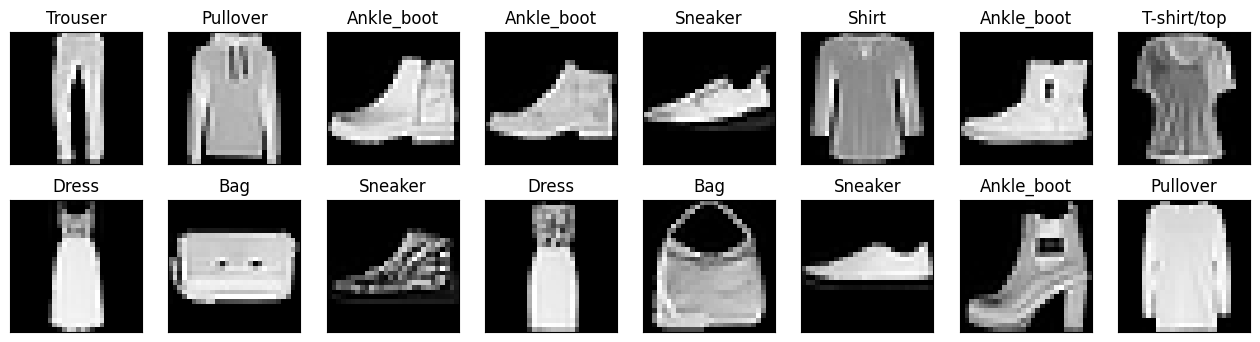

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(16, 4))  # Изменяем размер изображения и количество отображаемых картинок

for idx in range(16):  # Отображаем только 16 картинок
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx][0], cmap='gray')
    ax.set_title(str(CFG.classes[labels[idx].item()]))


Создаем полносвязаннную нейронную сеть.

In [ ]:
class My_Net(nn.Module): # наследуемся от класса nn.Module
      def __init__(self):
        super(My_Net, self).__init__()
        # Определение слоев нейронной сети
        self.fc1 = nn.Linear(in_features=784, out_features=128)  # Вход: 784 (28x28 пикселей), Выход: 128
        self.fc2 = nn.Linear(in_features=128, out_features=64)   # Вход: 128, Выход: 64
        self.fc3 = nn.Linear(in_features=64, out_features=10)    # Вход: 64, Выход: 10 (количество классов)

      def forward(self, x):
        # Определение прохода данных через сеть
        x = x.view(-1, 784)  # Переформатирование входных данных
        x = torch.relu(self.fc1(x))  # Применение ReLU к первому скрытому слою
        x = torch.relu(self.fc2(x))  # Применение ReLU ко второму скрытому слою
        x = self.fc3(x)  # Выходной слой без активации (на выходе получаем оценки классов)
        return x
      def count_hidden_layers(self):
        # Подсчитываем количество всех слоев (включая линейные)
        return len(list(self.children()))

In [ ]:
model = My_Net()
if torch.cuda.is_available():
    model = model.to('cuda')
print(model) # посмотрим на нашу модель

My_Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [ ]:
# функция потерь (cross-entropy) для 10 классов
criterion = nn.CrossEntropyLoss()

# SGD (классический) со скоростью обучения (learning rate) = 0.01
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
# функция обучения модели
def train(model, device, train_loader, optimizer, criterion, epoch, WANDB):
    model.train() # обязательно переводим в режим обучения
    test_loss = 0
    correct = 0

    n_ex = len(train_loader)

    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=n_ex):
        data, target = data.to(device), target.to(device) # переводим картинки и таргеты на GPU
        # обнуляем градиенты!
        optimizer.zero_grad()
        # прямой проход
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item() # определяем корректность предсказания
        train_loss = criterion(output, target) # считаем значение функции потерь
        # обратный проход
        train_loss.backward()
        # делаем градиентный шаг оптимизатором
        optimizer.step()
        # считаем метрики и лосс
    tqdm.write('\nTrain set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        train_loss, 100. * correct / len(train_loader.dataset)))

    if WANDB:
        wandb.log({'train_loss': train_loss,
                   'train_accuracy': correct / len(train_loader.dataset)})

In [ ]:
# функция тестирования
def test(model, device, test_loader, criterion, WANDB):
    global epoch
    model.eval() # переводем модель в режим инференса
    test_loss = 0
    correct = 0
    # показываем, что обучения нет и градиенты не обновляются
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() # считаем значение функции потерь
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # считаем метрики
    tqdm.write('Test set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        test_loss, 100. * correct / len(test_loader.dataset)))
    accuracy = 100. * correct / len(test_loader.dataset)

    if CFG.results_bool:
        if epoch == CFG.num_epochs - 1:
            # Создайте словарь с данными для добавления в DataFrame
            data = {'Оптимизатор': [str(type(optimizer).__name__)],
                    'Скорость обучения': [learning_rate],
                    'Количество скрытых слоев': [model.count_hidden_layers()],
                    'Accuracy': [accuracy]}
            temp_df = pd.DataFrame(data)
            CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)

    if WANDB:
        wandb.log({'test_loss': test_loss,
                   'test_accuracy': correct / len(test_loader.dataset)})

In [ ]:
# основная функция для экспериментов
def main(model):
    global epoch
    # настраиваем окружение для wandb
    optimizer_name = str(type(optimizer).__name__)
    name = str(optimizer_name) + '_' + str(learning_rate) + '_' + str(model.count_hidden_layers())
    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(project=CFG.project, entity=CFG.entity, name=name, reinit=True, config=class2dict(CFG))

    use_cuda = torch.cuda.is_available() # проверяем доступность GPU

    torch.manual_seed(CFG.seed)
    if use_cuda:
        torch.cuda.manual_seed(CFG.seed) # фиксируем сиды

    device = torch.device("cuda" if use_cuda else "cpu") # выделили устройство

    if CFG.wandb:
        wandb.watch(model, log='all') # логируем все (метрики, лоссы, градиенты)

    for epoch in range(1, CFG.num_epochs + 1): # цикл на эпохи
        print('\nEpoch:', epoch)
        train(model, device, train_loader, optimizer, criterion, epoch, CFG.wandb)
        test(model, device, test_loader, criterion, CFG.wandb)
    print('Training is end!')

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


Запускаем обучение. Цель - получить на тесте значение accuracy не менее 98%.

In [ ]:
main(model)


Epoch: 1


100%|██████████| 938/938 [00:38<00:00, 24.56it/s]



Train set: Average loss: 0.6912, Accuracy: 70%
Test set: Average loss: 11.7362, Accuracy: 78%

Epoch: 2


100%|██████████| 938/938 [00:30<00:00, 30.26it/s]



Train set: Average loss: 0.3211, Accuracy: 82%
Test set: Average loss: 9.9765, Accuracy: 82%

Epoch: 3


100%|██████████| 938/938 [00:18<00:00, 50.70it/s]



Train set: Average loss: 0.3568, Accuracy: 84%
Test set: Average loss: 9.4362, Accuracy: 83%

Epoch: 4


100%|██████████| 938/938 [00:19<00:00, 48.66it/s]



Train set: Average loss: 0.9602, Accuracy: 85%
Test set: Average loss: 8.9804, Accuracy: 83%

Epoch: 5


100%|██████████| 938/938 [00:19<00:00, 49.27it/s]



Train set: Average loss: 0.5765, Accuracy: 86%
Test set: Average loss: 8.6766, Accuracy: 84%

Epoch: 6


100%|██████████| 938/938 [00:20<00:00, 46.83it/s]



Train set: Average loss: 0.1892, Accuracy: 86%
Test set: Average loss: 8.3270, Accuracy: 85%

Epoch: 7


100%|██████████| 938/938 [00:18<00:00, 49.44it/s]



Train set: Average loss: 0.3581, Accuracy: 87%
Test set: Average loss: 8.6271, Accuracy: 84%

Epoch: 8


100%|██████████| 938/938 [00:20<00:00, 45.35it/s]



Train set: Average loss: 0.3157, Accuracy: 87%
Test set: Average loss: 7.9929, Accuracy: 86%

Epoch: 9


100%|██████████| 938/938 [00:18<00:00, 50.44it/s]



Train set: Average loss: 0.2918, Accuracy: 87%
Test set: Average loss: 7.8828, Accuracy: 86%

Epoch: 10


100%|██████████| 938/938 [00:19<00:00, 47.54it/s]



Train set: Average loss: 0.4726, Accuracy: 88%
Test set: Average loss: 7.9444, Accuracy: 86%
Training is end!


Проверим, работает ли датафрейм для сохранения результатов экспериментов

In [ ]:
CFG.result_df

,Оптимизатор,Скорость обучения,Количество скрытых слоев,Accuracy


Пробуем другие оптимизаторы.

In [ ]:
optimizers = ['Adam', 'SGD', 'RMSprop']
def choice_optimizer(choice, lr = 0.01):
    if choice == 'SGD':
        learning_rate = lr
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif choice == 'Adam':
        learning_rate = lr
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif choice == 'RMSprop':
        learning_rate = lr
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    return optimizer

In [ ]:
def summary():
    print('Summary')
    print('optimizer:', optimizer)
    print('--------------------------------------------------------------------------------------------------')


Может стоить добавить еще пару слоев? Как уже говорилось ранее, deep learning - это пространство для экспериментов и творчества. Дерзайте!

In [ ]:
def create_new_model(n=3):
    if n == 3:
        model = My_Net()
    elif n == 4:
        model = My_Net_4Layers()
    elif n == 5:
        model = My_Net_5Layers()
    else:
        raise ValueError("Недопустимое значение n. Допустимые значения: 3, 4, 5")

    if torch.cuda.is_available():
        model = model.to('cuda')

    return model


# Класс модели с 4 слоями

In [ ]:
class My_Net_4Layers(nn.Module):
    def __init__(self):
        super(My_Net_4Layers, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=128)  # Вход: 784 (28x28 пикселей), Выход: 128
        self.fc2 = nn.Linear(in_features=128, out_features=64)   # Вход: 128, Выход: 64
        self.fc3 = nn.Linear(in_features=64, out_features=32)    # Вход: 64, Выход: 32
        self.fc4 = nn.Linear(in_features=32, out_features=10)    # Вход: 32, Выход: 10 (количество классов)

    def forward(self, x):
        x = x.view(-1, 784)  # Переформатирование входных данных
        x = torch.relu(self.fc1(x))  # Применение ReLU к первому скрытому слою
        x = torch.relu(self.fc2(x))  # Применение ReLU ко второму скрытому слою
        x = torch.relu(self.fc3(x))  # Применение ReLU к третьему скрытому слою
        x = self.fc4(x)
        return x
    def count_hidden_layers(self):
        # Подсчитываем количество всех слоев (включая линейные)
        return len(list(self.children()))

# Класс для модели с 5 слоями

In [ ]:
class My_Net_5Layers(nn.Module):
    def __init__(self):
        super(My_Net_5Layers, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=128)  # Вход: 784 (28x28 пикселей), Выход: 128
        self.fc2 = nn.Linear(in_features=128, out_features=64)   # Вход: 128, Выход: 64
        self.fc3 = nn.Linear(in_features=64, out_features=32)    # Вход: 64, Выход: 32
        self.fc4 = nn.Linear(in_features=32, out_features=16)    # Вход: 32, Выход: 16
        self.fc5 = nn.Linear(in_features=16, out_features=10)    # Вход: 16, Выход: 10 (количество классов)

    def forward(self, x):
        x = x.view(-1, 784)  # Переформатирование входных данных
        x = torch.relu(self.fc1(x))  # Применение ReLU к первому скрытому слою
        x = torch.relu(self.fc2(x))  # Применение ReLU ко второму скрытому слою
        x = torch.relu(self.fc3(x))  # Применение ReLU к третьему скрытому слою
        x = torch.relu(self.fc4(x))  # Применение ReLU к четвертому скрытому слою
        x = self.fc5(x)  # Выходной слой без активации (на выходе получаем оценки классов)
        return x
    def count_hidden_layers(self):
        # Подсчитываем количество всех слоев (включая линейные)
        return len(list(self.children()))

array([0.01 , 0.007, 0.004, 0.001])

Попробуем прогнать по всем выбранным оптимизаторам модели, в которых 3-5 слоев со скоростями обучения от 0,011 до 0,001.

In [ ]:
CFG.results_bool = True #разрешим сохранение итоговых результатов в датафрейм
for i in optimizers: #прогон по всем оптимизаторам
    for k in np.linspace(0.01, 0.001, 4): #прогон по 4 скоростям
        for j in range(3,6): #количество скрытых слоев
            model = create_new_model(j)
            learning_rate = k
            optimizer = choice_optimizer(i, k)
            main(model)


Epoch: 1


100%|██████████| 938/938 [00:26<00:00, 35.05it/s]



Train set: Average loss: 0.4533, Accuracy: 81%
Test set: Average loss: 9.4218, Accuracy: 83%

Epoch: 2


100%|██████████| 938/938 [00:21<00:00, 44.58it/s]



Train set: Average loss: 0.2038, Accuracy: 85%
Test set: Average loss: 9.4489, Accuracy: 84%

Epoch: 3


100%|██████████| 938/938 [00:20<00:00, 46.33it/s]



Train set: Average loss: 0.2547, Accuracy: 86%
Test set: Average loss: 10.2297, Accuracy: 83%

Epoch: 4


100%|██████████| 938/938 [00:21<00:00, 43.46it/s]



Train set: Average loss: 0.8699, Accuracy: 86%
Test set: Average loss: 8.4996, Accuracy: 85%

Epoch: 5


100%|██████████| 938/938 [00:20<00:00, 44.91it/s]



Train set: Average loss: 0.8182, Accuracy: 86%
Test set: Average loss: 9.1559, Accuracy: 85%

Epoch: 6


100%|██████████| 938/938 [00:20<00:00, 46.08it/s]



Train set: Average loss: 0.1186, Accuracy: 87%
Test set: Average loss: 8.9380, Accuracy: 84%

Epoch: 7


100%|██████████| 938/938 [00:21<00:00, 43.13it/s]



Train set: Average loss: 0.2901, Accuracy: 87%
Test set: Average loss: 8.5978, Accuracy: 86%

Epoch: 8


100%|██████████| 938/938 [00:21<00:00, 44.32it/s]



Train set: Average loss: 0.3035, Accuracy: 87%
Test set: Average loss: 8.6154, Accuracy: 86%

Epoch: 9


100%|██████████| 938/938 [00:19<00:00, 47.36it/s]



Train set: Average loss: 0.2192, Accuracy: 88%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 8.3349, Accuracy: 85%

Epoch: 10


100%|██████████| 938/938 [00:20<00:00, 45.58it/s]



Train set: Average loss: 0.8312, Accuracy: 88%
Test set: Average loss: 8.4966, Accuracy: 86%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:21<00:00, 43.96it/s]



Train set: Average loss: 0.4475, Accuracy: 81%
Test set: Average loss: 10.4652, Accuracy: 82%

Epoch: 2


100%|██████████| 938/938 [00:20<00:00, 46.63it/s]



Train set: Average loss: 0.1586, Accuracy: 85%
Test set: Average loss: 9.6572, Accuracy: 84%

Epoch: 3


100%|██████████| 938/938 [00:21<00:00, 44.34it/s]



Train set: Average loss: 0.2554, Accuracy: 86%
Test set: Average loss: 9.2702, Accuracy: 84%

Epoch: 4


100%|██████████| 938/938 [00:21<00:00, 44.16it/s]



Train set: Average loss: 0.7707, Accuracy: 87%
Test set: Average loss: 8.4541, Accuracy: 85%

Epoch: 5


100%|██████████| 938/938 [00:20<00:00, 46.82it/s]



Train set: Average loss: 0.6144, Accuracy: 87%
Test set: Average loss: 8.8386, Accuracy: 85%

Epoch: 6


100%|██████████| 938/938 [00:23<00:00, 40.32it/s]



Train set: Average loss: 0.1738, Accuracy: 87%
Test set: Average loss: 8.8348, Accuracy: 85%

Epoch: 7


100%|██████████| 938/938 [00:21<00:00, 44.56it/s]



Train set: Average loss: 0.3515, Accuracy: 87%
Test set: Average loss: 8.1601, Accuracy: 86%

Epoch: 8


100%|██████████| 938/938 [00:20<00:00, 46.44it/s]



Train set: Average loss: 0.2249, Accuracy: 88%
Test set: Average loss: 8.1916, Accuracy: 86%

Epoch: 9


100%|██████████| 938/938 [00:21<00:00, 43.34it/s]



Train set: Average loss: 0.1825, Accuracy: 88%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 8.7829, Accuracy: 86%

Epoch: 10


100%|██████████| 938/938 [00:21<00:00, 43.94it/s]



Train set: Average loss: 0.3744, Accuracy: 88%
Test set: Average loss: 8.3954, Accuracy: 86%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:20<00:00, 45.73it/s]



Train set: Average loss: 0.3769, Accuracy: 80%
Test set: Average loss: 9.4750, Accuracy: 84%

Epoch: 2


100%|██████████| 938/938 [00:21<00:00, 42.94it/s]



Train set: Average loss: 0.2410, Accuracy: 85%
Test set: Average loss: 9.7521, Accuracy: 83%

Epoch: 3


100%|██████████| 938/938 [00:21<00:00, 43.42it/s]



Train set: Average loss: 0.3373, Accuracy: 86%
Test set: Average loss: 9.7636, Accuracy: 84%

Epoch: 4


100%|██████████| 938/938 [00:20<00:00, 45.62it/s]



Train set: Average loss: 0.7568, Accuracy: 87%
Test set: Average loss: 8.1884, Accuracy: 85%

Epoch: 5


100%|██████████| 938/938 [00:23<00:00, 39.23it/s]



Train set: Average loss: 0.7438, Accuracy: 87%
Test set: Average loss: 8.0383, Accuracy: 86%

Epoch: 6


100%|██████████| 938/938 [00:21<00:00, 42.75it/s]



Train set: Average loss: 0.2041, Accuracy: 87%
Test set: Average loss: 8.5910, Accuracy: 85%

Epoch: 7


100%|██████████| 938/938 [00:20<00:00, 45.37it/s]



Train set: Average loss: 0.3218, Accuracy: 88%
Test set: Average loss: 7.9332, Accuracy: 87%

Epoch: 8


100%|██████████| 938/938 [00:21<00:00, 43.28it/s]



Train set: Average loss: 0.2360, Accuracy: 88%
Test set: Average loss: 8.4017, Accuracy: 86%

Epoch: 9


100%|██████████| 938/938 [00:21<00:00, 43.14it/s]



Train set: Average loss: 0.2350, Accuracy: 88%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 8.0644, Accuracy: 86%

Epoch: 10


100%|██████████| 938/938 [00:20<00:00, 44.69it/s]



Train set: Average loss: 0.8385, Accuracy: 88%
Test set: Average loss: 8.9139, Accuracy: 86%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:20<00:00, 46.00it/s]



Train set: Average loss: 0.4450, Accuracy: 82%
Test set: Average loss: 9.2974, Accuracy: 83%

Epoch: 2


100%|██████████| 938/938 [00:21<00:00, 43.66it/s]



Train set: Average loss: 0.1906, Accuracy: 86%
Test set: Average loss: 8.5431, Accuracy: 84%

Epoch: 3


100%|██████████| 938/938 [00:20<00:00, 46.60it/s]



Train set: Average loss: 0.2333, Accuracy: 87%
Test set: Average loss: 8.8342, Accuracy: 84%

Epoch: 4


100%|██████████| 938/938 [00:22<00:00, 41.15it/s]



Train set: Average loss: 0.6717, Accuracy: 87%
Test set: Average loss: 8.1961, Accuracy: 85%

Epoch: 5


100%|██████████| 938/938 [00:20<00:00, 46.20it/s]



Train set: Average loss: 0.5753, Accuracy: 87%
Test set: Average loss: 8.0643, Accuracy: 86%

Epoch: 6


100%|██████████| 938/938 [00:20<00:00, 46.78it/s]



Train set: Average loss: 0.1011, Accuracy: 88%
Test set: Average loss: 8.2101, Accuracy: 86%

Epoch: 7


100%|██████████| 938/938 [00:21<00:00, 43.38it/s]



Train set: Average loss: 0.2950, Accuracy: 88%
Test set: Average loss: 8.0697, Accuracy: 86%

Epoch: 8


100%|██████████| 938/938 [00:20<00:00, 46.03it/s]



Train set: Average loss: 0.3313, Accuracy: 88%
Test set: Average loss: 8.3861, Accuracy: 86%

Epoch: 9


100%|██████████| 938/938 [00:20<00:00, 46.50it/s]



Train set: Average loss: 0.1597, Accuracy: 88%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 8.2361, Accuracy: 86%

Epoch: 10


100%|██████████| 938/938 [00:21<00:00, 43.57it/s]



Train set: Average loss: 0.4005, Accuracy: 88%
Test set: Average loss: 8.1480, Accuracy: 87%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:20<00:00, 46.41it/s]



Train set: Average loss: 0.5358, Accuracy: 82%
Test set: Average loss: 9.4745, Accuracy: 83%

Epoch: 2


100%|██████████| 938/938 [00:20<00:00, 46.58it/s]



Train set: Average loss: 0.1575, Accuracy: 86%
Test set: Average loss: 8.5254, Accuracy: 85%

Epoch: 3


100%|██████████| 938/938 [00:23<00:00, 40.10it/s]



Train set: Average loss: 0.2373, Accuracy: 87%
Test set: Average loss: 8.4919, Accuracy: 85%

Epoch: 4


100%|██████████| 938/938 [00:20<00:00, 45.97it/s]



Train set: Average loss: 0.7491, Accuracy: 87%
Test set: Average loss: 7.8481, Accuracy: 86%

Epoch: 5


100%|██████████| 938/938 [00:20<00:00, 46.62it/s]



Train set: Average loss: 0.6551, Accuracy: 88%
Test set: Average loss: 8.6876, Accuracy: 85%

Epoch: 6


100%|██████████| 938/938 [00:21<00:00, 43.20it/s]



Train set: Average loss: 0.0980, Accuracy: 88%
Test set: Average loss: 8.1274, Accuracy: 86%

Epoch: 7


100%|██████████| 938/938 [00:20<00:00, 46.00it/s]



Train set: Average loss: 0.2836, Accuracy: 88%
Test set: Average loss: 7.7508, Accuracy: 87%

Epoch: 8


100%|██████████| 938/938 [00:20<00:00, 46.12it/s]



Train set: Average loss: 0.2665, Accuracy: 89%
Test set: Average loss: 7.7244, Accuracy: 87%

Epoch: 9


100%|██████████| 938/938 [00:21<00:00, 43.15it/s]



Train set: Average loss: 0.1486, Accuracy: 89%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 8.2128, Accuracy: 86%

Epoch: 10


100%|██████████| 938/938 [00:21<00:00, 44.52it/s]



Train set: Average loss: 0.3538, Accuracy: 89%
Test set: Average loss: 7.9425, Accuracy: 87%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:22<00:00, 41.61it/s]



Train set: Average loss: 0.5268, Accuracy: 80%
Test set: Average loss: 9.2322, Accuracy: 84%

Epoch: 2


100%|██████████| 938/938 [00:23<00:00, 39.82it/s]



Train set: Average loss: 0.2244, Accuracy: 85%
Test set: Average loss: 8.3263, Accuracy: 85%

Epoch: 3


100%|██████████| 938/938 [00:22<00:00, 41.89it/s]



Train set: Average loss: 0.2925, Accuracy: 87%
Test set: Average loss: 8.7859, Accuracy: 84%

Epoch: 4


100%|██████████| 938/938 [00:21<00:00, 43.81it/s]



Train set: Average loss: 0.7876, Accuracy: 88%
Test set: Average loss: 8.0250, Accuracy: 86%

Epoch: 5


100%|██████████| 938/938 [00:20<00:00, 45.28it/s]



Train set: Average loss: 0.6917, Accuracy: 88%
Test set: Average loss: 8.1246, Accuracy: 86%

Epoch: 6


100%|██████████| 938/938 [00:22<00:00, 42.38it/s]



Train set: Average loss: 0.1074, Accuracy: 88%
Test set: Average loss: 7.7353, Accuracy: 86%

Epoch: 7


100%|██████████| 938/938 [00:22<00:00, 41.97it/s]



Train set: Average loss: 0.3296, Accuracy: 89%
Test set: Average loss: 8.1301, Accuracy: 86%

Epoch: 8


100%|██████████| 938/938 [00:20<00:00, 45.53it/s]



Train set: Average loss: 0.2658, Accuracy: 88%
Test set: Average loss: 7.9785, Accuracy: 86%

Epoch: 9


100%|██████████| 938/938 [00:21<00:00, 43.52it/s]



Train set: Average loss: 0.1469, Accuracy: 89%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 7.5435, Accuracy: 87%

Epoch: 10


100%|██████████| 938/938 [00:22<00:00, 42.44it/s]



Train set: Average loss: 0.4913, Accuracy: 89%
Test set: Average loss: 7.6623, Accuracy: 87%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:21<00:00, 43.12it/s]



Train set: Average loss: 0.3439, Accuracy: 82%
Test set: Average loss: 8.4677, Accuracy: 84%

Epoch: 2


100%|██████████| 938/938 [00:19<00:00, 47.05it/s]



Train set: Average loss: 0.1361, Accuracy: 86%
Test set: Average loss: 7.8146, Accuracy: 86%

Epoch: 3


100%|██████████| 938/938 [00:21<00:00, 43.89it/s]



Train set: Average loss: 0.1902, Accuracy: 87%
Test set: Average loss: 8.4785, Accuracy: 84%

Epoch: 4


100%|██████████| 938/938 [00:20<00:00, 46.30it/s]



Train set: Average loss: 0.4821, Accuracy: 88%
Test set: Average loss: 7.6834, Accuracy: 86%

Epoch: 5


100%|██████████| 938/938 [00:20<00:00, 46.64it/s]



Train set: Average loss: 0.6168, Accuracy: 88%
Test set: Average loss: 8.1554, Accuracy: 85%

Epoch: 6


100%|██████████| 938/938 [00:21<00:00, 43.95it/s]



Train set: Average loss: 0.0885, Accuracy: 89%
Test set: Average loss: 7.3144, Accuracy: 87%

Epoch: 7


100%|██████████| 938/938 [00:19<00:00, 47.52it/s]



Train set: Average loss: 0.3048, Accuracy: 89%
Test set: Average loss: 7.2728, Accuracy: 87%

Epoch: 8


100%|██████████| 938/938 [00:20<00:00, 45.21it/s]



Train set: Average loss: 0.3108, Accuracy: 90%
Test set: Average loss: 7.4629, Accuracy: 87%

Epoch: 9


100%|██████████| 938/938 [00:20<00:00, 45.22it/s]



Train set: Average loss: 0.3588, Accuracy: 90%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 7.6987, Accuracy: 87%

Epoch: 10


100%|██████████| 938/938 [00:20<00:00, 44.95it/s]



Train set: Average loss: 0.3652, Accuracy: 90%
Test set: Average loss: 7.3165, Accuracy: 88%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:21<00:00, 44.66it/s]



Train set: Average loss: 0.4511, Accuracy: 82%
Test set: Average loss: 8.7102, Accuracy: 84%

Epoch: 2


100%|██████████| 938/938 [00:21<00:00, 43.99it/s]



Train set: Average loss: 0.1535, Accuracy: 86%
Test set: Average loss: 7.9295, Accuracy: 85%

Epoch: 3


100%|██████████| 938/938 [00:20<00:00, 45.72it/s]



Train set: Average loss: 0.2511, Accuracy: 87%
Test set: Average loss: 8.5740, Accuracy: 85%

Epoch: 4


100%|██████████| 938/938 [00:21<00:00, 44.02it/s]



Train set: Average loss: 0.8297, Accuracy: 88%
Test set: Average loss: 7.3186, Accuracy: 87%

Epoch: 5


100%|██████████| 938/938 [00:21<00:00, 43.69it/s]



Train set: Average loss: 0.5971, Accuracy: 89%
Test set: Average loss: 7.2817, Accuracy: 87%

Epoch: 6


100%|██████████| 938/938 [00:20<00:00, 46.27it/s]



Train set: Average loss: 0.0944, Accuracy: 89%
Test set: Average loss: 7.3428, Accuracy: 87%

Epoch: 7


100%|██████████| 938/938 [00:21<00:00, 43.77it/s]



Train set: Average loss: 0.1737, Accuracy: 89%
Test set: Average loss: 7.1778, Accuracy: 87%

Epoch: 8


100%|██████████| 938/938 [00:23<00:00, 40.15it/s]



Train set: Average loss: 0.2944, Accuracy: 90%
Test set: Average loss: 7.2773, Accuracy: 87%

Epoch: 9


100%|██████████| 938/938 [00:20<00:00, 46.31it/s]



Train set: Average loss: 0.1411, Accuracy: 90%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 7.3318, Accuracy: 88%

Epoch: 10


100%|██████████| 938/938 [00:21<00:00, 43.53it/s]



Train set: Average loss: 0.2749, Accuracy: 90%
Test set: Average loss: 7.0475, Accuracy: 88%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:21<00:00, 42.71it/s]



Train set: Average loss: 0.4496, Accuracy: 81%
Test set: Average loss: 9.1869, Accuracy: 83%

Epoch: 2


100%|██████████| 938/938 [00:20<00:00, 45.57it/s]



Train set: Average loss: 0.1241, Accuracy: 86%
Test set: Average loss: 7.8222, Accuracy: 86%

Epoch: 3


100%|██████████| 938/938 [00:21<00:00, 43.15it/s]



Train set: Average loss: 0.2662, Accuracy: 88%
Test set: Average loss: 8.1035, Accuracy: 85%

Epoch: 4


100%|██████████| 938/938 [00:22<00:00, 42.53it/s]



Train set: Average loss: 0.6245, Accuracy: 88%
Test set: Average loss: 7.7143, Accuracy: 86%

Epoch: 5


100%|██████████| 938/938 [00:20<00:00, 45.13it/s]



Train set: Average loss: 0.5603, Accuracy: 89%
Test set: Average loss: 7.8039, Accuracy: 86%

Epoch: 6


100%|██████████| 938/938 [00:21<00:00, 44.56it/s]



Train set: Average loss: 0.1077, Accuracy: 89%
Test set: Average loss: 7.3648, Accuracy: 87%

Epoch: 7


100%|██████████| 938/938 [00:23<00:00, 39.62it/s]



Train set: Average loss: 0.2635, Accuracy: 89%
Test set: Average loss: 6.9762, Accuracy: 88%

Epoch: 8


100%|██████████| 938/938 [00:20<00:00, 45.71it/s]



Train set: Average loss: 0.2424, Accuracy: 90%
Test set: Average loss: 7.2140, Accuracy: 87%

Epoch: 9


100%|██████████| 938/938 [00:20<00:00, 45.49it/s]



Train set: Average loss: 0.0917, Accuracy: 90%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 7.5028, Accuracy: 88%

Epoch: 10


100%|██████████| 938/938 [00:21<00:00, 42.90it/s]



Train set: Average loss: 0.3197, Accuracy: 91%
Test set: Average loss: 7.1883, Accuracy: 88%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:19<00:00, 47.10it/s]



Train set: Average loss: 0.3808, Accuracy: 82%
Test set: Average loss: 8.4938, Accuracy: 84%

Epoch: 2


100%|██████████| 938/938 [00:19<00:00, 47.12it/s]



Train set: Average loss: 0.1496, Accuracy: 87%
Test set: Average loss: 7.3546, Accuracy: 87%

Epoch: 3


100%|██████████| 938/938 [00:21<00:00, 43.81it/s]



Train set: Average loss: 0.2059, Accuracy: 88%
Test set: Average loss: 7.4805, Accuracy: 86%

Epoch: 4


100%|██████████| 938/938 [00:19<00:00, 47.46it/s]



Train set: Average loss: 0.5684, Accuracy: 89%
Test set: Average loss: 6.8187, Accuracy: 87%

Epoch: 5


100%|██████████| 938/938 [00:21<00:00, 44.53it/s]



Train set: Average loss: 0.5083, Accuracy: 90%
Test set: Average loss: 7.1222, Accuracy: 87%

Epoch: 6


100%|██████████| 938/938 [00:22<00:00, 40.83it/s]



Train set: Average loss: 0.0679, Accuracy: 90%
Test set: Average loss: 6.6978, Accuracy: 88%

Epoch: 7


100%|██████████| 938/938 [00:20<00:00, 46.86it/s]



Train set: Average loss: 0.2888, Accuracy: 91%
Test set: Average loss: 6.9273, Accuracy: 87%

Epoch: 8


100%|██████████| 938/938 [00:21<00:00, 44.52it/s]



Train set: Average loss: 0.2134, Accuracy: 91%
Test set: Average loss: 6.6094, Accuracy: 88%

Epoch: 9


100%|██████████| 938/938 [00:20<00:00, 45.37it/s]



Train set: Average loss: 0.0916, Accuracy: 92%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 6.7659, Accuracy: 88%

Epoch: 10


100%|██████████| 938/938 [00:19<00:00, 47.34it/s]



Train set: Average loss: 0.3393, Accuracy: 92%
Test set: Average loss: 6.7037, Accuracy: 89%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:21<00:00, 43.41it/s]



Train set: Average loss: 0.3747, Accuracy: 82%
Test set: Average loss: 8.4981, Accuracy: 84%

Epoch: 2


100%|██████████| 938/938 [00:20<00:00, 45.67it/s]



Train set: Average loss: 0.1456, Accuracy: 87%
Test set: Average loss: 7.6050, Accuracy: 86%

Epoch: 3


100%|██████████| 938/938 [00:20<00:00, 46.68it/s]



Train set: Average loss: 0.2210, Accuracy: 88%
Test set: Average loss: 7.6619, Accuracy: 86%

Epoch: 4


100%|██████████| 938/938 [00:21<00:00, 43.13it/s]



Train set: Average loss: 0.5397, Accuracy: 89%
Test set: Average loss: 6.9781, Accuracy: 87%

Epoch: 5


100%|██████████| 938/938 [00:22<00:00, 42.45it/s]



Train set: Average loss: 0.5260, Accuracy: 89%
Test set: Average loss: 6.9172, Accuracy: 87%

Epoch: 6


100%|██████████| 938/938 [00:20<00:00, 46.74it/s]



Train set: Average loss: 0.0680, Accuracy: 90%
Test set: Average loss: 6.8507, Accuracy: 88%

Epoch: 7


100%|██████████| 938/938 [00:21<00:00, 43.47it/s]



Train set: Average loss: 0.2852, Accuracy: 91%
Test set: Average loss: 6.9606, Accuracy: 87%

Epoch: 8


100%|██████████| 938/938 [00:25<00:00, 36.70it/s]



Train set: Average loss: 0.2113, Accuracy: 91%
Test set: Average loss: 6.7809, Accuracy: 88%

Epoch: 9


100%|██████████| 938/938 [00:20<00:00, 46.31it/s]



Train set: Average loss: 0.0672, Accuracy: 91%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 6.8246, Accuracy: 88%

Epoch: 10


100%|██████████| 938/938 [00:20<00:00, 45.34it/s]



Train set: Average loss: 0.3355, Accuracy: 92%
Test set: Average loss: 6.8844, Accuracy: 88%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:22<00:00, 42.48it/s]



Train set: Average loss: 0.4089, Accuracy: 79%
Test set: Average loss: 9.3608, Accuracy: 83%

Epoch: 2


100%|██████████| 938/938 [00:20<00:00, 45.88it/s]



Train set: Average loss: 0.2127, Accuracy: 86%
Test set: Average loss: 7.8462, Accuracy: 86%

Epoch: 3


100%|██████████| 938/938 [00:21<00:00, 43.11it/s]



Train set: Average loss: 0.2147, Accuracy: 87%
Test set: Average loss: 7.5931, Accuracy: 86%

Epoch: 4


100%|██████████| 938/938 [00:22<00:00, 42.22it/s]



Train set: Average loss: 0.6810, Accuracy: 88%
Test set: Average loss: 7.1230, Accuracy: 87%

Epoch: 5


100%|██████████| 938/938 [00:21<00:00, 43.50it/s]



Train set: Average loss: 0.5029, Accuracy: 89%
Test set: Average loss: 7.0426, Accuracy: 87%

Epoch: 6


100%|██████████| 938/938 [00:20<00:00, 45.64it/s]



Train set: Average loss: 0.1152, Accuracy: 90%
Test set: Average loss: 6.8886, Accuracy: 88%

Epoch: 7


100%|██████████| 938/938 [00:21<00:00, 42.95it/s]



Train set: Average loss: 0.2895, Accuracy: 90%
Test set: Average loss: 6.8241, Accuracy: 88%

Epoch: 8


100%|██████████| 938/938 [00:21<00:00, 43.43it/s]



Train set: Average loss: 0.2180, Accuracy: 90%
Test set: Average loss: 6.9118, Accuracy: 87%

Epoch: 9


100%|██████████| 938/938 [00:20<00:00, 46.03it/s]



Train set: Average loss: 0.1283, Accuracy: 91%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 7.0532, Accuracy: 88%

Epoch: 10


100%|██████████| 938/938 [00:21<00:00, 43.25it/s]



Train set: Average loss: 0.2603, Accuracy: 91%
Test set: Average loss: 6.7784, Accuracy: 88%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:19<00:00, 48.89it/s]



Train set: Average loss: 0.6842, Accuracy: 70%
Test set: Average loss: 11.9617, Accuracy: 78%

Epoch: 2


100%|██████████| 938/938 [00:20<00:00, 45.55it/s]



Train set: Average loss: 0.3168, Accuracy: 82%
Test set: Average loss: 10.0358, Accuracy: 82%

Epoch: 3


100%|██████████| 938/938 [00:19<00:00, 46.94it/s]



Train set: Average loss: 0.3551, Accuracy: 84%
Test set: Average loss: 9.4834, Accuracy: 83%

Epoch: 4


100%|██████████| 938/938 [00:18<00:00, 49.66it/s]



Train set: Average loss: 0.9128, Accuracy: 85%
Test set: Average loss: 8.9229, Accuracy: 84%

Epoch: 5


100%|██████████| 938/938 [00:20<00:00, 46.29it/s]



Train set: Average loss: 0.6306, Accuracy: 86%
Test set: Average loss: 8.6308, Accuracy: 84%

Epoch: 6


100%|██████████| 938/938 [00:18<00:00, 49.61it/s]



Train set: Average loss: 0.1918, Accuracy: 86%
Test set: Average loss: 8.2646, Accuracy: 85%

Epoch: 7


100%|██████████| 938/938 [00:20<00:00, 46.06it/s]



Train set: Average loss: 0.3263, Accuracy: 87%
Test set: Average loss: 8.5241, Accuracy: 84%

Epoch: 8


100%|██████████| 938/938 [00:19<00:00, 49.29it/s]



Train set: Average loss: 0.3257, Accuracy: 87%
Test set: Average loss: 7.9309, Accuracy: 86%

Epoch: 9


100%|██████████| 938/938 [00:19<00:00, 47.30it/s]



Train set: Average loss: 0.2949, Accuracy: 87%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 7.8058, Accuracy: 86%

Epoch: 10


100%|██████████| 938/938 [00:18<00:00, 49.48it/s]



Train set: Average loss: 0.4263, Accuracy: 88%
Test set: Average loss: 7.8831, Accuracy: 86%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:19<00:00, 48.12it/s]



Train set: Average loss: 0.8271, Accuracy: 60%
Test set: Average loss: 13.5959, Accuracy: 75%

Epoch: 2


100%|██████████| 938/938 [00:21<00:00, 43.38it/s]



Train set: Average loss: 0.3918, Accuracy: 79%
Test set: Average loss: 11.0070, Accuracy: 80%

Epoch: 3


100%|██████████| 938/938 [00:19<00:00, 49.10it/s]



Train set: Average loss: 0.3809, Accuracy: 83%
Test set: Average loss: 9.8914, Accuracy: 82%

Epoch: 4


100%|██████████| 938/938 [00:20<00:00, 45.83it/s]



Train set: Average loss: 0.9548, Accuracy: 84%
Test set: Average loss: 9.3296, Accuracy: 83%

Epoch: 5


100%|██████████| 938/938 [00:19<00:00, 49.32it/s]



Train set: Average loss: 0.6620, Accuracy: 85%
Test set: Average loss: 8.9831, Accuracy: 84%

Epoch: 6


100%|██████████| 938/938 [00:20<00:00, 45.70it/s]



Train set: Average loss: 0.2296, Accuracy: 86%
Test set: Average loss: 8.4794, Accuracy: 85%

Epoch: 7


100%|██████████| 938/938 [00:18<00:00, 49.54it/s]



Train set: Average loss: 0.3835, Accuracy: 86%
Test set: Average loss: 8.8138, Accuracy: 84%

Epoch: 8


100%|██████████| 938/938 [00:19<00:00, 47.27it/s]



Train set: Average loss: 0.3190, Accuracy: 87%
Test set: Average loss: 7.9211, Accuracy: 86%

Epoch: 9


100%|██████████| 938/938 [00:19<00:00, 48.57it/s]



Train set: Average loss: 0.2976, Accuracy: 87%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 7.8720, Accuracy: 86%

Epoch: 10


100%|██████████| 938/938 [00:18<00:00, 49.45it/s]



Train set: Average loss: 0.4367, Accuracy: 87%
Test set: Average loss: 8.0447, Accuracy: 86%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:22<00:00, 42.06it/s]



Train set: Average loss: 1.1021, Accuracy: 30%
Test set: Average loss: 18.2936, Accuracy: 66%

Epoch: 2


100%|██████████| 938/938 [00:19<00:00, 48.74it/s]



Train set: Average loss: 0.5314, Accuracy: 75%
Test set: Average loss: 12.3577, Accuracy: 77%

Epoch: 3


100%|██████████| 938/938 [00:20<00:00, 46.20it/s]



Train set: Average loss: 0.4333, Accuracy: 81%
Test set: Average loss: 10.6535, Accuracy: 81%

Epoch: 4


100%|██████████| 938/938 [00:19<00:00, 47.67it/s]



Train set: Average loss: 0.9170, Accuracy: 83%
Test set: Average loss: 10.4019, Accuracy: 81%

Epoch: 5


100%|██████████| 938/938 [00:19<00:00, 48.18it/s]



Train set: Average loss: 0.6335, Accuracy: 84%
Test set: Average loss: 9.3487, Accuracy: 83%

Epoch: 6


100%|██████████| 938/938 [00:21<00:00, 44.41it/s]



Train set: Average loss: 0.2193, Accuracy: 85%
Test set: Average loss: 8.8880, Accuracy: 84%

Epoch: 7


100%|██████████| 938/938 [00:20<00:00, 44.95it/s]



Train set: Average loss: 0.3458, Accuracy: 86%
Test set: Average loss: 9.2507, Accuracy: 83%

Epoch: 8


100%|██████████| 938/938 [00:20<00:00, 45.37it/s]



Train set: Average loss: 0.3379, Accuracy: 86%
Test set: Average loss: 8.1229, Accuracy: 85%

Epoch: 9


100%|██████████| 938/938 [00:21<00:00, 44.01it/s]



Train set: Average loss: 0.2654, Accuracy: 87%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 8.1605, Accuracy: 86%

Epoch: 10


100%|██████████| 938/938 [00:19<00:00, 46.96it/s]



Train set: Average loss: 0.4944, Accuracy: 87%
Test set: Average loss: 7.9623, Accuracy: 86%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:19<00:00, 47.69it/s]



Train set: Average loss: 0.7612, Accuracy: 67%
Test set: Average loss: 12.9407, Accuracy: 76%

Epoch: 2


100%|██████████| 938/938 [00:20<00:00, 46.77it/s]



Train set: Average loss: 0.3849, Accuracy: 80%
Test set: Average loss: 10.7458, Accuracy: 80%

Epoch: 3


100%|██████████| 938/938 [00:19<00:00, 48.84it/s]



Train set: Average loss: 0.3839, Accuracy: 83%
Test set: Average loss: 10.0218, Accuracy: 82%

Epoch: 4


100%|██████████| 938/938 [00:20<00:00, 45.53it/s]



Train set: Average loss: 0.9251, Accuracy: 84%
Test set: Average loss: 9.4556, Accuracy: 82%

Epoch: 5


100%|██████████| 938/938 [00:19<00:00, 48.92it/s]



Train set: Average loss: 0.6689, Accuracy: 85%
Test set: Average loss: 9.1156, Accuracy: 83%

Epoch: 6


100%|██████████| 938/938 [00:24<00:00, 37.73it/s]



Train set: Average loss: 0.2281, Accuracy: 85%
Test set: Average loss: 8.7318, Accuracy: 84%

Epoch: 7


100%|██████████| 938/938 [00:20<00:00, 45.70it/s]



Train set: Average loss: 0.3464, Accuracy: 86%
Test set: Average loss: 8.8427, Accuracy: 84%

Epoch: 8


100%|██████████| 938/938 [00:20<00:00, 45.23it/s]



Train set: Average loss: 0.3421, Accuracy: 86%
Test set: Average loss: 8.3286, Accuracy: 85%

Epoch: 9


100%|██████████| 938/938 [00:20<00:00, 46.58it/s]



Train set: Average loss: 0.3265, Accuracy: 87%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 8.1828, Accuracy: 85%

Epoch: 10


100%|██████████| 938/938 [00:19<00:00, 49.20it/s]



Train set: Average loss: 0.4486, Accuracy: 87%
Test set: Average loss: 8.1942, Accuracy: 85%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:19<00:00, 48.35it/s]



Train set: Average loss: 0.9164, Accuracy: 54%
Test set: Average loss: 15.1957, Accuracy: 74%

Epoch: 2


100%|██████████| 938/938 [00:19<00:00, 47.03it/s]



Train set: Average loss: 0.5117, Accuracy: 76%
Test set: Average loss: 12.0752, Accuracy: 78%

Epoch: 3


100%|██████████| 938/938 [00:19<00:00, 49.01it/s]



Train set: Average loss: 0.4052, Accuracy: 80%
Test set: Average loss: 10.7958, Accuracy: 80%

Epoch: 4


100%|██████████| 938/938 [00:20<00:00, 45.13it/s]



Train set: Average loss: 0.9614, Accuracy: 83%
Test set: Average loss: 10.0665, Accuracy: 81%

Epoch: 5


100%|██████████| 938/938 [00:19<00:00, 48.64it/s]



Train set: Average loss: 0.6894, Accuracy: 84%
Test set: Average loss: 9.6412, Accuracy: 82%

Epoch: 6


100%|██████████| 938/938 [00:20<00:00, 45.61it/s]



Train set: Average loss: 0.2763, Accuracy: 85%
Test set: Average loss: 9.1074, Accuracy: 84%

Epoch: 7


100%|██████████| 938/938 [00:20<00:00, 44.69it/s]



Train set: Average loss: 0.3840, Accuracy: 85%
Test set: Average loss: 9.3208, Accuracy: 83%

Epoch: 8


100%|██████████| 938/938 [00:19<00:00, 48.57it/s]



Train set: Average loss: 0.3666, Accuracy: 86%
Test set: Average loss: 8.5190, Accuracy: 85%

Epoch: 9


100%|██████████| 938/938 [00:20<00:00, 46.65it/s]



Train set: Average loss: 0.3214, Accuracy: 86%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 8.4231, Accuracy: 85%

Epoch: 10


100%|██████████| 938/938 [00:19<00:00, 48.73it/s]



Train set: Average loss: 0.5005, Accuracy: 86%
Test set: Average loss: 8.4820, Accuracy: 85%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:20<00:00, 45.16it/s]



Train set: Average loss: 1.8283, Accuracy: 19%
Test set: Average loss: 34.8706, Accuracy: 40%

Epoch: 2


100%|██████████| 938/938 [00:19<00:00, 48.27it/s]



Train set: Average loss: 0.7278, Accuracy: 64%
Test set: Average loss: 14.0357, Accuracy: 74%

Epoch: 3


100%|██████████| 938/938 [00:20<00:00, 44.98it/s]



Train set: Average loss: 0.4663, Accuracy: 78%
Test set: Average loss: 11.7067, Accuracy: 79%

Epoch: 4


100%|██████████| 938/938 [00:19<00:00, 47.54it/s]



Train set: Average loss: 0.9146, Accuracy: 81%
Test set: Average loss: 11.1315, Accuracy: 80%

Epoch: 5


100%|██████████| 938/938 [00:20<00:00, 45.05it/s]



Train set: Average loss: 0.6330, Accuracy: 82%
Test set: Average loss: 10.2041, Accuracy: 82%

Epoch: 6


100%|██████████| 938/938 [00:20<00:00, 45.01it/s]



Train set: Average loss: 0.2845, Accuracy: 83%
Test set: Average loss: 9.6813, Accuracy: 82%

Epoch: 7


100%|██████████| 938/938 [00:19<00:00, 47.90it/s]



Train set: Average loss: 0.3726, Accuracy: 84%
Test set: Average loss: 9.7387, Accuracy: 82%

Epoch: 8


100%|██████████| 938/938 [00:20<00:00, 45.99it/s]



Train set: Average loss: 0.4003, Accuracy: 85%
Test set: Average loss: 8.7493, Accuracy: 85%

Epoch: 9


100%|██████████| 938/938 [00:19<00:00, 47.87it/s]



Train set: Average loss: 0.3390, Accuracy: 86%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 8.6470, Accuracy: 85%

Epoch: 10


100%|██████████| 938/938 [00:19<00:00, 48.39it/s]



Train set: Average loss: 0.5358, Accuracy: 86%
Test set: Average loss: 8.5083, Accuracy: 85%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:20<00:00, 45.41it/s]



Train set: Average loss: 0.9301, Accuracy: 61%
Test set: Average loss: 15.7049, Accuracy: 74%

Epoch: 2


100%|██████████| 938/938 [00:19<00:00, 49.03it/s]



Train set: Average loss: 0.5228, Accuracy: 77%
Test set: Average loss: 12.2685, Accuracy: 78%

Epoch: 3


100%|██████████| 938/938 [00:20<00:00, 45.67it/s]



Train set: Average loss: 0.4392, Accuracy: 80%
Test set: Average loss: 11.1415, Accuracy: 80%

Epoch: 4


100%|██████████| 938/938 [00:20<00:00, 44.77it/s]



Train set: Average loss: 0.9095, Accuracy: 82%
Test set: Average loss: 10.4739, Accuracy: 81%

Epoch: 5


100%|██████████| 938/938 [00:20<00:00, 46.00it/s]



Train set: Average loss: 0.6909, Accuracy: 83%
Test set: Average loss: 10.0180, Accuracy: 82%

Epoch: 6


100%|██████████| 938/938 [00:19<00:00, 49.03it/s]



Train set: Average loss: 0.3087, Accuracy: 84%
Test set: Average loss: 9.6073, Accuracy: 82%

Epoch: 7


100%|██████████| 938/938 [00:20<00:00, 46.85it/s]



Train set: Average loss: 0.4057, Accuracy: 84%
Test set: Average loss: 9.4850, Accuracy: 83%

Epoch: 8


100%|██████████| 938/938 [00:22<00:00, 41.52it/s]



Train set: Average loss: 0.3846, Accuracy: 85%
Test set: Average loss: 9.0949, Accuracy: 84%

Epoch: 9


100%|██████████| 938/938 [00:19<00:00, 49.13it/s]



Train set: Average loss: 0.3636, Accuracy: 85%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 8.9024, Accuracy: 84%

Epoch: 10


100%|██████████| 938/938 [00:19<00:00, 48.03it/s]



Train set: Average loss: 0.5061, Accuracy: 86%
Test set: Average loss: 8.8061, Accuracy: 84%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:20<00:00, 46.17it/s]



Train set: Average loss: 1.2164, Accuracy: 42%
Test set: Average loss: 21.5011, Accuracy: 67%

Epoch: 2


100%|██████████| 938/938 [00:20<00:00, 44.96it/s]



Train set: Average loss: 0.7019, Accuracy: 72%
Test set: Average loss: 14.1170, Accuracy: 74%

Epoch: 3


100%|██████████| 938/938 [00:20<00:00, 45.39it/s]



Train set: Average loss: 0.4682, Accuracy: 76%
Test set: Average loss: 12.4455, Accuracy: 77%

Epoch: 4


100%|██████████| 938/938 [00:19<00:00, 48.94it/s]



Train set: Average loss: 0.9492, Accuracy: 79%
Test set: Average loss: 11.5252, Accuracy: 79%

Epoch: 5


100%|██████████| 938/938 [00:20<00:00, 46.61it/s]



Train set: Average loss: 0.7046, Accuracy: 81%
Test set: Average loss: 10.9151, Accuracy: 80%

Epoch: 6


100%|██████████| 938/938 [00:19<00:00, 47.90it/s]



Train set: Average loss: 0.3909, Accuracy: 82%
Test set: Average loss: 10.2732, Accuracy: 81%

Epoch: 7


100%|██████████| 938/938 [00:19<00:00, 48.50it/s]



Train set: Average loss: 0.4313, Accuracy: 83%
Test set: Average loss: 10.0919, Accuracy: 81%

Epoch: 8


100%|██████████| 938/938 [00:20<00:00, 45.18it/s]



Train set: Average loss: 0.4372, Accuracy: 84%
Test set: Average loss: 9.5162, Accuracy: 83%

Epoch: 9


100%|██████████| 938/938 [00:19<00:00, 48.38it/s]



Train set: Average loss: 0.3582, Accuracy: 84%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 9.2894, Accuracy: 84%

Epoch: 10


100%|██████████| 938/938 [00:20<00:00, 45.26it/s]



Train set: Average loss: 0.5648, Accuracy: 85%
Test set: Average loss: 9.1954, Accuracy: 84%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:21<00:00, 44.60it/s]



Train set: Average loss: 2.2541, Accuracy: 11%
Test set: Average loss: 44.9760, Accuracy: 16%

Epoch: 2


100%|██████████| 938/938 [00:20<00:00, 46.76it/s]



Train set: Average loss: 1.3349, Accuracy: 33%
Test set: Average loss: 26.7115, Accuracy: 51%

Epoch: 3


100%|██████████| 938/938 [00:20<00:00, 46.54it/s]



Train set: Average loss: 0.6106, Accuracy: 65%
Test set: Average loss: 15.1750, Accuracy: 72%

Epoch: 4


100%|██████████| 938/938 [00:23<00:00, 40.74it/s]



Train set: Average loss: 1.0256, Accuracy: 75%
Test set: Average loss: 12.8486, Accuracy: 77%

Epoch: 5


100%|██████████| 938/938 [00:19<00:00, 47.01it/s]



Train set: Average loss: 0.6370, Accuracy: 78%
Test set: Average loss: 11.7793, Accuracy: 79%

Epoch: 6


100%|██████████| 938/938 [00:20<00:00, 46.13it/s]



Train set: Average loss: 0.4189, Accuracy: 80%
Test set: Average loss: 11.1623, Accuracy: 79%

Epoch: 7


100%|██████████| 938/938 [00:19<00:00, 47.96it/s]



Train set: Average loss: 0.4082, Accuracy: 81%
Test set: Average loss: 10.8213, Accuracy: 80%

Epoch: 8


100%|██████████| 938/938 [00:21<00:00, 44.56it/s]



Train set: Average loss: 0.4936, Accuracy: 82%
Test set: Average loss: 10.1787, Accuracy: 82%

Epoch: 9


100%|██████████| 938/938 [00:21<00:00, 44.61it/s]



Train set: Average loss: 0.4295, Accuracy: 83%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 9.8484, Accuracy: 82%

Epoch: 10


100%|██████████| 938/938 [00:19<00:00, 47.69it/s]



Train set: Average loss: 0.6883, Accuracy: 84%
Test set: Average loss: 9.5591, Accuracy: 83%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:24<00:00, 37.60it/s]



Train set: Average loss: 1.7712, Accuracy: 45%
Test set: Average loss: 34.2560, Accuracy: 55%

Epoch: 2


100%|██████████| 938/938 [00:19<00:00, 48.08it/s]



Train set: Average loss: 1.1341, Accuracy: 59%
Test set: Average loss: 22.4329, Accuracy: 64%

Epoch: 3


100%|██████████| 938/938 [00:19<00:00, 48.95it/s]



Train set: Average loss: 0.7793, Accuracy: 68%
Test set: Average loss: 17.9988, Accuracy: 70%

Epoch: 4


100%|██████████| 938/938 [00:20<00:00, 46.58it/s]



Train set: Average loss: 1.1739, Accuracy: 73%
Test set: Average loss: 15.7124, Accuracy: 73%

Epoch: 5


100%|██████████| 938/938 [00:19<00:00, 49.34it/s]



Train set: Average loss: 0.7945, Accuracy: 75%
Test set: Average loss: 14.3048, Accuracy: 75%

Epoch: 6


100%|██████████| 938/938 [00:20<00:00, 45.55it/s]



Train set: Average loss: 0.6413, Accuracy: 76%
Test set: Average loss: 13.3776, Accuracy: 76%

Epoch: 7


100%|██████████| 938/938 [00:19<00:00, 48.86it/s]



Train set: Average loss: 0.6377, Accuracy: 77%
Test set: Average loss: 12.7585, Accuracy: 77%

Epoch: 8


100%|██████████| 938/938 [00:20<00:00, 45.62it/s]



Train set: Average loss: 0.5024, Accuracy: 78%
Test set: Average loss: 12.2719, Accuracy: 78%

Epoch: 9


100%|██████████| 938/938 [00:19<00:00, 48.44it/s]



Train set: Average loss: 0.5125, Accuracy: 79%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 11.8887, Accuracy: 79%

Epoch: 10


100%|██████████| 938/938 [00:19<00:00, 49.01it/s]



Train set: Average loss: 0.7363, Accuracy: 80%
Test set: Average loss: 11.5689, Accuracy: 79%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:20<00:00, 46.72it/s]



Train set: Average loss: 2.1882, Accuracy: 28%
Test set: Average loss: 44.0218, Accuracy: 32%

Epoch: 2


100%|██████████| 938/938 [00:19<00:00, 49.10it/s]



Train set: Average loss: 1.9275, Accuracy: 34%
Test set: Average loss: 38.5016, Accuracy: 37%

Epoch: 3


100%|██████████| 938/938 [00:20<00:00, 45.52it/s]



Train set: Average loss: 1.3798, Accuracy: 43%
Test set: Average loss: 28.0358, Accuracy: 53%

Epoch: 4


100%|██████████| 938/938 [00:19<00:00, 48.82it/s]



Train set: Average loss: 1.4584, Accuracy: 62%
Test set: Average loss: 21.4643, Accuracy: 66%

Epoch: 5


100%|██████████| 938/938 [00:20<00:00, 45.57it/s]



Train set: Average loss: 0.9055, Accuracy: 69%
Test set: Average loss: 18.1961, Accuracy: 71%

Epoch: 6


100%|██████████| 938/938 [00:20<00:00, 44.76it/s]



Train set: Average loss: 0.7682, Accuracy: 72%
Test set: Average loss: 16.1824, Accuracy: 72%

Epoch: 7


100%|██████████| 938/938 [00:20<00:00, 45.89it/s]



Train set: Average loss: 0.7370, Accuracy: 73%
Test set: Average loss: 14.9256, Accuracy: 73%

Epoch: 8


100%|██████████| 938/938 [00:19<00:00, 48.46it/s]



Train set: Average loss: 0.5630, Accuracy: 74%
Test set: Average loss: 14.0679, Accuracy: 74%

Epoch: 9


100%|██████████| 938/938 [00:19<00:00, 48.32it/s]



Train set: Average loss: 0.5825, Accuracy: 75%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 13.4637, Accuracy: 75%

Epoch: 10


100%|██████████| 938/938 [00:20<00:00, 46.16it/s]



Train set: Average loss: 0.8477, Accuracy: 76%
Test set: Average loss: 12.9938, Accuracy: 76%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:19<00:00, 48.47it/s]



Train set: Average loss: 2.3063, Accuracy: 10%
Test set: Average loss: 46.1376, Accuracy: 10%

Epoch: 2


100%|██████████| 938/938 [00:24<00:00, 38.63it/s]



Train set: Average loss: 2.3231, Accuracy: 10%
Test set: Average loss: 45.8347, Accuracy: 10%

Epoch: 3


100%|██████████| 938/938 [00:20<00:00, 46.08it/s]



Train set: Average loss: 2.2934, Accuracy: 10%
Test set: Average loss: 45.4797, Accuracy: 11%

Epoch: 4


100%|██████████| 938/938 [00:21<00:00, 44.09it/s]



Train set: Average loss: 2.2563, Accuracy: 13%
Test set: Average loss: 44.9770, Accuracy: 16%

Epoch: 5


100%|██████████| 938/938 [00:20<00:00, 45.44it/s]



Train set: Average loss: 2.2356, Accuracy: 22%
Test set: Average loss: 44.0001, Accuracy: 27%

Epoch: 6


100%|██████████| 938/938 [00:19<00:00, 48.23it/s]



Train set: Average loss: 2.0495, Accuracy: 30%
Test set: Average loss: 41.5867, Accuracy: 33%

Epoch: 7


100%|██████████| 938/938 [00:20<00:00, 45.53it/s]



Train set: Average loss: 1.7244, Accuracy: 38%
Test set: Average loss: 34.9066, Accuracy: 39%

Epoch: 8


100%|██████████| 938/938 [00:19<00:00, 47.08it/s]



Train set: Average loss: 1.3125, Accuracy: 44%
Test set: Average loss: 26.7093, Accuracy: 52%

Epoch: 9


100%|██████████| 938/938 [00:19<00:00, 47.66it/s]



Train set: Average loss: 1.0341, Accuracy: 57%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 20.7365, Accuracy: 62%

Epoch: 10


100%|██████████| 938/938 [00:21<00:00, 44.46it/s]



Train set: Average loss: 1.0285, Accuracy: 64%
Test set: Average loss: 17.8688, Accuracy: 65%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:20<00:00, 46.78it/s]



Train set: Average loss: 0.4522, Accuracy: 79%
Test set: Average loss: 10.4770, Accuracy: 82%

Epoch: 2


100%|██████████| 938/938 [00:22<00:00, 41.82it/s]



Train set: Average loss: 0.3313, Accuracy: 84%
Test set: Average loss: 9.7144, Accuracy: 82%

Epoch: 3


100%|██████████| 938/938 [00:20<00:00, 44.99it/s]



Train set: Average loss: 0.3063, Accuracy: 84%
Test set: Average loss: 9.8071, Accuracy: 83%

Epoch: 4


100%|██████████| 938/938 [00:19<00:00, 47.38it/s]



Train set: Average loss: 0.6497, Accuracy: 85%
Test set: Average loss: 10.7146, Accuracy: 79%

Epoch: 5


100%|██████████| 938/938 [00:21<00:00, 44.02it/s]



Train set: Average loss: 0.7615, Accuracy: 85%
Test set: Average loss: 12.3913, Accuracy: 81%

Epoch: 6


100%|██████████| 938/938 [00:19<00:00, 47.55it/s]



Train set: Average loss: 0.2469, Accuracy: 85%
Test set: Average loss: 12.0529, Accuracy: 81%

Epoch: 7


100%|██████████| 938/938 [00:19<00:00, 47.46it/s]



Train set: Average loss: 0.3163, Accuracy: 86%
Test set: Average loss: 10.0406, Accuracy: 84%

Epoch: 8


100%|██████████| 938/938 [00:21<00:00, 43.09it/s]



Train set: Average loss: 0.3114, Accuracy: 86%
Test set: Average loss: 9.2650, Accuracy: 85%

Epoch: 9


100%|██████████| 938/938 [00:21<00:00, 44.09it/s]



Train set: Average loss: 0.2665, Accuracy: 86%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 9.5435, Accuracy: 84%

Epoch: 10


100%|██████████| 938/938 [00:23<00:00, 39.32it/s]



Train set: Average loss: 0.4224, Accuracy: 86%
Test set: Average loss: 10.4941, Accuracy: 84%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:20<00:00, 45.50it/s]



Train set: Average loss: 0.4916, Accuracy: 76%
Test set: Average loss: 10.9732, Accuracy: 81%

Epoch: 2


100%|██████████| 938/938 [00:20<00:00, 45.72it/s]



Train set: Average loss: 0.3268, Accuracy: 83%
Test set: Average loss: 10.4613, Accuracy: 82%

Epoch: 3


100%|██████████| 938/938 [00:19<00:00, 47.38it/s]



Train set: Average loss: 0.2744, Accuracy: 84%
Test set: Average loss: 10.5307, Accuracy: 83%

Epoch: 4


100%|██████████| 938/938 [00:21<00:00, 44.00it/s]



Train set: Average loss: 0.5382, Accuracy: 85%
Test set: Average loss: 13.3991, Accuracy: 76%

Epoch: 5


100%|██████████| 938/938 [00:19<00:00, 47.32it/s]



Train set: Average loss: 0.6276, Accuracy: 86%
Test set: Average loss: 10.9234, Accuracy: 82%

Epoch: 6


100%|██████████| 938/938 [00:21<00:00, 43.74it/s]



Train set: Average loss: 0.2662, Accuracy: 86%
Test set: Average loss: 9.1533, Accuracy: 84%

Epoch: 7


100%|██████████| 938/938 [00:21<00:00, 43.69it/s]



Train set: Average loss: 0.3007, Accuracy: 86%
Test set: Average loss: 10.5834, Accuracy: 81%

Epoch: 8


100%|██████████| 938/938 [00:22<00:00, 42.45it/s]



Train set: Average loss: 0.3375, Accuracy: 86%
Test set: Average loss: 9.1666, Accuracy: 85%

Epoch: 9


100%|██████████| 938/938 [00:20<00:00, 45.75it/s]



Train set: Average loss: 0.2539, Accuracy: 86%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 9.0609, Accuracy: 85%

Epoch: 10


100%|██████████| 938/938 [00:22<00:00, 42.22it/s]



Train set: Average loss: 0.3942, Accuracy: 86%
Test set: Average loss: 10.0753, Accuracy: 83%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:20<00:00, 46.24it/s]



Train set: Average loss: 0.5137, Accuracy: 74%
Test set: Average loss: 12.3689, Accuracy: 79%

Epoch: 2


100%|██████████| 938/938 [00:19<00:00, 47.02it/s]



Train set: Average loss: 0.3189, Accuracy: 83%
Test set: Average loss: 10.4796, Accuracy: 82%

Epoch: 3


100%|██████████| 938/938 [00:21<00:00, 43.09it/s]



Train set: Average loss: 0.4216, Accuracy: 84%
Test set: Average loss: 9.7689, Accuracy: 82%

Epoch: 4


100%|██████████| 938/938 [00:20<00:00, 46.38it/s]



Train set: Average loss: 0.7840, Accuracy: 85%
Test set: Average loss: 10.5857, Accuracy: 80%

Epoch: 5


100%|██████████| 938/938 [00:21<00:00, 44.42it/s]



Train set: Average loss: 0.6113, Accuracy: 86%
Test set: Average loss: 10.1504, Accuracy: 84%

Epoch: 6


100%|██████████| 938/938 [00:22<00:00, 41.49it/s]



Train set: Average loss: 0.1860, Accuracy: 86%
Test set: Average loss: 9.6150, Accuracy: 84%

Epoch: 7


100%|██████████| 938/938 [00:20<00:00, 45.91it/s]



Train set: Average loss: 0.2757, Accuracy: 86%
Test set: Average loss: 9.1261, Accuracy: 85%

Epoch: 8


100%|██████████| 938/938 [00:22<00:00, 41.71it/s]



Train set: Average loss: 0.3410, Accuracy: 86%
Test set: Average loss: 8.8444, Accuracy: 85%

Epoch: 9


100%|██████████| 938/938 [00:22<00:00, 41.80it/s]



Train set: Average loss: 0.2943, Accuracy: 87%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 8.8596, Accuracy: 86%

Epoch: 10


100%|██████████| 938/938 [00:21<00:00, 43.51it/s]



Train set: Average loss: 0.6067, Accuracy: 87%
Test set: Average loss: 16.2830, Accuracy: 75%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:20<00:00, 45.70it/s]



Train set: Average loss: 0.4793, Accuracy: 80%
Test set: Average loss: 9.8846, Accuracy: 83%

Epoch: 2


100%|██████████| 938/938 [00:21<00:00, 44.48it/s]



Train set: Average loss: 0.1675, Accuracy: 85%
Test set: Average loss: 9.0692, Accuracy: 84%

Epoch: 3


100%|██████████| 938/938 [00:19<00:00, 47.45it/s]



Train set: Average loss: 0.3174, Accuracy: 86%
Test set: Average loss: 9.4906, Accuracy: 84%

Epoch: 4


100%|██████████| 938/938 [00:23<00:00, 40.44it/s]



Train set: Average loss: 0.8076, Accuracy: 86%
Test set: Average loss: 11.0232, Accuracy: 79%

Epoch: 5


100%|██████████| 938/938 [00:19<00:00, 47.28it/s]



Train set: Average loss: 0.6873, Accuracy: 87%
Test set: Average loss: 9.6681, Accuracy: 84%

Epoch: 6


100%|██████████| 938/938 [00:20<00:00, 46.57it/s]



Train set: Average loss: 0.1866, Accuracy: 87%
Test set: Average loss: 8.7008, Accuracy: 85%

Epoch: 7


100%|██████████| 938/938 [00:21<00:00, 43.52it/s]



Train set: Average loss: 0.2250, Accuracy: 87%
Test set: Average loss: 9.7250, Accuracy: 84%

Epoch: 8


100%|██████████| 938/938 [00:20<00:00, 46.07it/s]



Train set: Average loss: 0.2992, Accuracy: 87%
Test set: Average loss: 8.6325, Accuracy: 85%

Epoch: 9


100%|██████████| 938/938 [00:21<00:00, 42.73it/s]



Train set: Average loss: 0.3856, Accuracy: 87%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 14.5831, Accuracy: 78%

Epoch: 10


100%|██████████| 938/938 [00:22<00:00, 41.72it/s]



Train set: Average loss: 0.3731, Accuracy: 87%
Test set: Average loss: 9.8033, Accuracy: 84%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:20<00:00, 46.55it/s]



Train set: Average loss: 0.5687, Accuracy: 79%
Test set: Average loss: 12.5228, Accuracy: 78%

Epoch: 2


100%|██████████| 938/938 [00:22<00:00, 40.84it/s]



Train set: Average loss: 0.2492, Accuracy: 84%
Test set: Average loss: 9.0327, Accuracy: 83%

Epoch: 3


100%|██████████| 938/938 [00:20<00:00, 45.81it/s]



Train set: Average loss: 0.3115, Accuracy: 85%
Test set: Average loss: 8.5407, Accuracy: 85%

Epoch: 4


100%|██████████| 938/938 [00:19<00:00, 47.14it/s]



Train set: Average loss: 0.6175, Accuracy: 86%
Test set: Average loss: 11.0080, Accuracy: 80%

Epoch: 5


100%|██████████| 938/938 [00:21<00:00, 43.49it/s]



Train set: Average loss: 0.5975, Accuracy: 87%
Test set: Average loss: 9.6774, Accuracy: 84%

Epoch: 6


100%|██████████| 938/938 [00:19<00:00, 46.93it/s]



Train set: Average loss: 0.1335, Accuracy: 87%
Test set: Average loss: 8.2183, Accuracy: 86%

Epoch: 7


100%|██████████| 938/938 [00:20<00:00, 45.45it/s]



Train set: Average loss: 0.2234, Accuracy: 87%
Test set: Average loss: 8.6190, Accuracy: 85%

Epoch: 8


100%|██████████| 938/938 [00:21<00:00, 42.80it/s]



Train set: Average loss: 0.3739, Accuracy: 87%
Test set: Average loss: 8.6979, Accuracy: 85%

Epoch: 9


100%|██████████| 938/938 [00:21<00:00, 44.20it/s]



Train set: Average loss: 0.2300, Accuracy: 87%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 7.9610, Accuracy: 86%

Epoch: 10


100%|██████████| 938/938 [00:23<00:00, 40.10it/s]



Train set: Average loss: 0.6511, Accuracy: 88%
Test set: Average loss: 9.0098, Accuracy: 85%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:21<00:00, 43.94it/s]



Train set: Average loss: 0.6398, Accuracy: 78%
Test set: Average loss: 10.5491, Accuracy: 82%

Epoch: 2


100%|██████████| 938/938 [00:20<00:00, 45.60it/s]



Train set: Average loss: 0.3325, Accuracy: 84%
Test set: Average loss: 9.4119, Accuracy: 84%

Epoch: 3


100%|██████████| 938/938 [00:20<00:00, 46.75it/s]



Train set: Average loss: 0.2907, Accuracy: 85%
Test set: Average loss: 9.1940, Accuracy: 84%

Epoch: 4


100%|██████████| 938/938 [00:21<00:00, 42.99it/s]



Train set: Average loss: 0.9477, Accuracy: 86%
Test set: Average loss: 12.6893, Accuracy: 75%

Epoch: 5


100%|██████████| 938/938 [00:20<00:00, 45.91it/s]



Train set: Average loss: 0.5675, Accuracy: 86%
Test set: Average loss: 9.3371, Accuracy: 84%

Epoch: 6


100%|██████████| 938/938 [00:20<00:00, 46.44it/s]



Train set: Average loss: 0.1929, Accuracy: 87%
Test set: Average loss: 8.4123, Accuracy: 85%

Epoch: 7


100%|██████████| 938/938 [00:22<00:00, 42.62it/s]



Train set: Average loss: 0.2754, Accuracy: 87%
Test set: Average loss: 9.9614, Accuracy: 84%

Epoch: 8


100%|██████████| 938/938 [00:22<00:00, 41.55it/s]



Train set: Average loss: 0.3122, Accuracy: 87%
Test set: Average loss: 8.3311, Accuracy: 86%

Epoch: 9


100%|██████████| 938/938 [00:20<00:00, 44.85it/s]



Train set: Average loss: 0.2193, Accuracy: 87%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 8.1158, Accuracy: 86%

Epoch: 10


100%|██████████| 938/938 [00:23<00:00, 39.68it/s]



Train set: Average loss: 0.4997, Accuracy: 88%
Test set: Average loss: 10.0956, Accuracy: 84%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:20<00:00, 44.85it/s]



Train set: Average loss: 0.4171, Accuracy: 82%
Test set: Average loss: 9.9593, Accuracy: 82%

Epoch: 2


100%|██████████| 938/938 [00:19<00:00, 47.86it/s]



Train set: Average loss: 0.1583, Accuracy: 86%
Test set: Average loss: 8.4749, Accuracy: 85%

Epoch: 3


100%|██████████| 938/938 [00:21<00:00, 44.21it/s]



Train set: Average loss: 0.2799, Accuracy: 87%
Test set: Average loss: 8.4877, Accuracy: 85%

Epoch: 4


100%|██████████| 938/938 [00:19<00:00, 47.75it/s]



Train set: Average loss: 0.6954, Accuracy: 88%
Test set: Average loss: 9.2162, Accuracy: 84%

Epoch: 5


100%|██████████| 938/938 [00:21<00:00, 42.96it/s]



Train set: Average loss: 0.5654, Accuracy: 88%
Test set: Average loss: 8.5953, Accuracy: 86%

Epoch: 6


100%|██████████| 938/938 [00:21<00:00, 44.64it/s]



Train set: Average loss: 0.0827, Accuracy: 88%
Test set: Average loss: 8.1287, Accuracy: 86%

Epoch: 7


100%|██████████| 938/938 [00:20<00:00, 46.68it/s]



Train set: Average loss: 0.3329, Accuracy: 89%
Test set: Average loss: 8.7727, Accuracy: 86%

Epoch: 8


100%|██████████| 938/938 [00:21<00:00, 43.77it/s]



Train set: Average loss: 0.3274, Accuracy: 89%
Test set: Average loss: 7.7378, Accuracy: 87%

Epoch: 9


100%|██████████| 938/938 [00:21<00:00, 43.46it/s]



Train set: Average loss: 0.1610, Accuracy: 89%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 8.7285, Accuracy: 87%

Epoch: 10


100%|██████████| 938/938 [00:21<00:00, 43.93it/s]



Train set: Average loss: 0.4280, Accuracy: 89%
Test set: Average loss: 8.8907, Accuracy: 86%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:20<00:00, 44.75it/s]



Train set: Average loss: 0.3624, Accuracy: 81%
Test set: Average loss: 8.9217, Accuracy: 84%

Epoch: 2


100%|██████████| 938/938 [00:20<00:00, 45.53it/s]



Train set: Average loss: 0.1741, Accuracy: 86%
Test set: Average loss: 8.6702, Accuracy: 85%

Epoch: 3


100%|██████████| 938/938 [00:21<00:00, 43.06it/s]



Train set: Average loss: 0.3183, Accuracy: 87%
Test set: Average loss: 8.3967, Accuracy: 85%

Epoch: 4


100%|██████████| 938/938 [00:21<00:00, 43.60it/s]



Train set: Average loss: 0.8321, Accuracy: 88%
Test set: Average loss: 9.0503, Accuracy: 83%

Epoch: 5


100%|██████████| 938/938 [00:20<00:00, 46.56it/s]



Train set: Average loss: 0.6569, Accuracy: 88%
Test set: Average loss: 8.8076, Accuracy: 85%

Epoch: 6


100%|██████████| 938/938 [00:21<00:00, 44.35it/s]



Train set: Average loss: 0.3275, Accuracy: 89%
Test set: Average loss: 9.0685, Accuracy: 85%

Epoch: 7


100%|██████████| 938/938 [00:21<00:00, 43.37it/s]



Train set: Average loss: 0.2348, Accuracy: 89%
Test set: Average loss: 8.1806, Accuracy: 86%

Epoch: 8


100%|██████████| 938/938 [00:20<00:00, 45.60it/s]



Train set: Average loss: 0.2277, Accuracy: 89%
Test set: Average loss: 7.5664, Accuracy: 87%

Epoch: 9


100%|██████████| 938/938 [00:22<00:00, 41.99it/s]



Train set: Average loss: 0.1506, Accuracy: 89%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 7.9439, Accuracy: 86%

Epoch: 10


100%|██████████| 938/938 [00:23<00:00, 40.01it/s]



Train set: Average loss: 0.3912, Accuracy: 90%
Test set: Average loss: 8.4120, Accuracy: 86%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:20<00:00, 45.39it/s]



Train set: Average loss: 0.4536, Accuracy: 80%
Test set: Average loss: 9.3987, Accuracy: 83%

Epoch: 2


100%|██████████| 938/938 [00:20<00:00, 46.06it/s]



Train set: Average loss: 0.2199, Accuracy: 85%
Test set: Average loss: 8.8826, Accuracy: 84%

Epoch: 3


100%|██████████| 938/938 [00:21<00:00, 43.29it/s]



Train set: Average loss: 0.3001, Accuracy: 87%
Test set: Average loss: 8.1700, Accuracy: 86%

Epoch: 4


100%|██████████| 938/938 [00:20<00:00, 45.76it/s]



Train set: Average loss: 0.5561, Accuracy: 88%
Test set: Average loss: 9.6142, Accuracy: 82%

Epoch: 5


100%|██████████| 938/938 [00:20<00:00, 46.58it/s]



Train set: Average loss: 0.7445, Accuracy: 88%
Test set: Average loss: 9.5652, Accuracy: 84%

Epoch: 6


100%|██████████| 938/938 [00:21<00:00, 43.02it/s]



Train set: Average loss: 0.1493, Accuracy: 88%
Test set: Average loss: 7.9407, Accuracy: 86%

Epoch: 7


100%|██████████| 938/938 [00:20<00:00, 46.44it/s]



Train set: Average loss: 0.2426, Accuracy: 89%
Test set: Average loss: 7.9413, Accuracy: 86%

Epoch: 8


100%|██████████| 938/938 [00:22<00:00, 40.86it/s]



Train set: Average loss: 0.2149, Accuracy: 89%
Test set: Average loss: 7.4202, Accuracy: 87%

Epoch: 9


100%|██████████| 938/938 [00:22<00:00, 42.03it/s]



Train set: Average loss: 0.1649, Accuracy: 89%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 7.6287, Accuracy: 87%

Epoch: 10


100%|██████████| 938/938 [00:20<00:00, 44.99it/s]



Train set: Average loss: 0.3436, Accuracy: 90%
Test set: Average loss: 8.6098, Accuracy: 87%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:20<00:00, 45.71it/s]



Train set: Average loss: 0.3483, Accuracy: 83%
Test set: Average loss: 8.7999, Accuracy: 83%

Epoch: 2


100%|██████████| 938/938 [00:20<00:00, 45.57it/s]



Train set: Average loss: 0.1646, Accuracy: 87%
Test set: Average loss: 7.7049, Accuracy: 86%

Epoch: 3


100%|██████████| 938/938 [00:19<00:00, 47.36it/s]



Train set: Average loss: 0.2296, Accuracy: 88%
Test set: Average loss: 7.2606, Accuracy: 87%

Epoch: 4


100%|██████████| 938/938 [00:21<00:00, 43.66it/s]



Train set: Average loss: 0.4033, Accuracy: 89%
Test set: Average loss: 7.7667, Accuracy: 85%

Epoch: 5


100%|██████████| 938/938 [00:19<00:00, 47.77it/s]



Train set: Average loss: 0.5764, Accuracy: 90%
Test set: Average loss: 7.6006, Accuracy: 86%

Epoch: 6


100%|██████████| 938/938 [00:21<00:00, 42.85it/s]



Train set: Average loss: 0.0626, Accuracy: 90%
Test set: Average loss: 6.8135, Accuracy: 88%

Epoch: 7


100%|██████████| 938/938 [00:21<00:00, 44.06it/s]



Train set: Average loss: 0.2241, Accuracy: 91%
Test set: Average loss: 8.1378, Accuracy: 85%

Epoch: 8


100%|██████████| 938/938 [00:19<00:00, 47.58it/s]



Train set: Average loss: 0.2072, Accuracy: 91%
Test set: Average loss: 7.0617, Accuracy: 88%

Epoch: 9


100%|██████████| 938/938 [00:21<00:00, 44.44it/s]



Train set: Average loss: 0.1166, Accuracy: 92%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 6.6974, Accuracy: 89%

Epoch: 10


100%|██████████| 938/938 [00:20<00:00, 46.58it/s]



Train set: Average loss: 0.2622, Accuracy: 92%
Test set: Average loss: 7.0830, Accuracy: 88%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:20<00:00, 46.69it/s]



Train set: Average loss: 0.4048, Accuracy: 82%
Test set: Average loss: 8.6311, Accuracy: 84%

Epoch: 2


100%|██████████| 938/938 [00:21<00:00, 43.39it/s]



Train set: Average loss: 0.1339, Accuracy: 87%
Test set: Average loss: 7.9494, Accuracy: 85%

Epoch: 3


100%|██████████| 938/938 [00:20<00:00, 45.63it/s]



Train set: Average loss: 0.2540, Accuracy: 88%
Test set: Average loss: 7.5150, Accuracy: 86%

Epoch: 4


100%|██████████| 938/938 [00:21<00:00, 44.48it/s]



Train set: Average loss: 0.5077, Accuracy: 89%
Test set: Average loss: 8.6261, Accuracy: 84%

Epoch: 5


100%|██████████| 938/938 [00:21<00:00, 44.49it/s]



Train set: Average loss: 0.5213, Accuracy: 90%
Test set: Average loss: 7.4638, Accuracy: 86%

Epoch: 6


100%|██████████| 938/938 [00:20<00:00, 46.64it/s]



Train set: Average loss: 0.0637, Accuracy: 90%
Test set: Average loss: 6.9111, Accuracy: 88%

Epoch: 7


100%|██████████| 938/938 [00:21<00:00, 43.29it/s]



Train set: Average loss: 0.2801, Accuracy: 91%
Test set: Average loss: 7.3279, Accuracy: 86%

Epoch: 8


100%|██████████| 938/938 [00:20<00:00, 45.54it/s]



Train set: Average loss: 0.1961, Accuracy: 91%
Test set: Average loss: 7.0423, Accuracy: 88%

Epoch: 9


100%|██████████| 938/938 [00:20<00:00, 46.07it/s]



Train set: Average loss: 0.1085, Accuracy: 91%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 6.9035, Accuracy: 89%

Epoch: 10


100%|██████████| 938/938 [00:21<00:00, 43.37it/s]



Train set: Average loss: 0.2822, Accuracy: 92%
Test set: Average loss: 7.2838, Accuracy: 87%
Training is end!

Epoch: 1


100%|██████████| 938/938 [00:22<00:00, 42.58it/s]



Train set: Average loss: 0.3743, Accuracy: 80%
Test set: Average loss: 9.3838, Accuracy: 83%

Epoch: 2


100%|██████████| 938/938 [00:21<00:00, 43.71it/s]



Train set: Average loss: 0.2079, Accuracy: 86%
Test set: Average loss: 8.4247, Accuracy: 85%

Epoch: 3


100%|██████████| 938/938 [00:20<00:00, 45.39it/s]



Train set: Average loss: 0.2427, Accuracy: 87%
Test set: Average loss: 7.6949, Accuracy: 86%

Epoch: 4


100%|██████████| 938/938 [00:20<00:00, 46.38it/s]



Train set: Average loss: 0.6140, Accuracy: 88%
Test set: Average loss: 8.7827, Accuracy: 84%

Epoch: 5


100%|██████████| 938/938 [00:21<00:00, 43.25it/s]



Train set: Average loss: 0.6367, Accuracy: 89%
Test set: Average loss: 8.0518, Accuracy: 86%

Epoch: 6


100%|██████████| 938/938 [00:20<00:00, 46.00it/s]



Train set: Average loss: 0.0615, Accuracy: 90%
Test set: Average loss: 7.0771, Accuracy: 87%

Epoch: 7


100%|██████████| 938/938 [00:20<00:00, 45.21it/s]



Train set: Average loss: 0.2851, Accuracy: 90%
Test set: Average loss: 7.4948, Accuracy: 87%

Epoch: 8


100%|██████████| 938/938 [00:23<00:00, 39.16it/s]



Train set: Average loss: 0.2025, Accuracy: 91%
Test set: Average loss: 6.9880, Accuracy: 88%

Epoch: 9


100%|██████████| 938/938 [00:20<00:00, 44.91it/s]



Train set: Average loss: 0.1394, Accuracy: 91%


<ipython-input-41-8de805c8ef19>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  CFG.result_df = CFG.result_df.append(temp_df, ignore_index=True)


Test set: Average loss: 7.0745, Accuracy: 88%

Epoch: 10


100%|██████████| 938/938 [00:21<00:00, 44.22it/s]



Train set: Average loss: 0.3347, Accuracy: 91%
Test set: Average loss: 7.0125, Accuracy: 88%
Training is end!


# Анализ полученных результатов

Посмотрим на результаты, полученные в результате реализации данных моделей и сохраним результаты в csv-файл

In [ ]:
CFG.result_df

,Оптимизатор,Скорость обучения,Количество скрытых слоев,Accuracy
0,Adam,0.010,3,85.47
1,Adam,0.010,4,85.68
2,Adam,0.010,5,86.50
3,Adam,0.007,3,86.11
4,Adam,0.007,4,86.50
5,Adam,0.007,5,86.83
6,Adam,0.004,3,87.14
7,Adam,0.004,4,87.86
8,Adam,0.004,5,87.51
9,Adam,0.001,3,88.01


In [ ]:
CFG.result_df.to_csv('res.csv', index=False)

Найдем модели с самым большим значением accuracy

In [ ]:
CFG.result_df.nlargest(3, 'Accuracy')

,Оптимизатор,Скорость обучения,Количество скрытых слоев,Accuracy
34,RMSprop,0.001,4,88.65
33,RMSprop,0.001,3,88.63
10,Adam,0.001,4,88.37


Т.о. самые лучшие результаты имеют модели со скоростью обучения 0.01, с оптимизаторами RMSprop (3,4 скрытых слоя) и Адам 4 слоя.

Отключим запись в датасет

In [ ]:
CFG.results_bool = False

Для начала попробуем включить Амсград:

In [ ]:
CFG.wandb = True
model = create_new_model(4)
optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
main(model)

wandb: Currently logged in as: forleg5pro. Use `wandb login --relogin` to force relogin



Epoch: 1


100%|██████████| 938/938 [00:20<00:00, 44.80it/s]



Train set: Average loss: 0.4021, Accuracy: 82%
Test set: Average loss: 8.6311, Accuracy: 84%

Epoch: 2


100%|██████████| 938/938 [00:22<00:00, 42.57it/s]



Train set: Average loss: 0.1256, Accuracy: 87%
Test set: Average loss: 7.5760, Accuracy: 86%

Epoch: 3


100%|██████████| 938/938 [00:22<00:00, 40.89it/s]



Train set: Average loss: 0.2139, Accuracy: 88%
Test set: Average loss: 7.6298, Accuracy: 86%

Epoch: 4


100%|██████████| 938/938 [00:25<00:00, 36.36it/s]



Train set: Average loss: 0.6395, Accuracy: 89%
Test set: Average loss: 7.1288, Accuracy: 87%

Epoch: 5


100%|██████████| 938/938 [00:21<00:00, 43.27it/s]



Train set: Average loss: 0.4459, Accuracy: 89%
Test set: Average loss: 6.9025, Accuracy: 87%

Epoch: 6


100%|██████████| 938/938 [00:22<00:00, 41.65it/s]



Train set: Average loss: 0.0631, Accuracy: 90%
Test set: Average loss: 6.9144, Accuracy: 88%

Epoch: 7


100%|██████████| 938/938 [00:29<00:00, 32.32it/s]



Train set: Average loss: 0.2584, Accuracy: 91%
Test set: Average loss: 6.7403, Accuracy: 88%

Epoch: 8


100%|██████████| 938/938 [00:24<00:00, 37.95it/s]



Train set: Average loss: 0.2057, Accuracy: 91%
Test set: Average loss: 6.7003, Accuracy: 88%

Epoch: 9


100%|██████████| 938/938 [00:20<00:00, 45.63it/s]



Train set: Average loss: 0.0637, Accuracy: 91%
Test set: Average loss: 6.7907, Accuracy: 88%

Epoch: 10


100%|██████████| 938/938 [00:21<00:00, 42.67it/s]



Train set: Average loss: 0.3306, Accuracy: 92%
Test set: Average loss: 6.5950, Accuracy: 88%
Training is end!


Получили результат 88.46%, что незначительно отличается от предыдущего результата. Попробуем уменьшить размер батча с 64 до 32.

In [ ]:
CFG.train_batch_size = 32

In [ ]:
model = create_new_model(4)
optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
main(model)

test_accuracy,▁▄▄▆▆▇▇▇▇█
test_loss,█▄▅▃▂▂▁▁▂▁
train_accuracy,▁▅▅▆▆▇▇▇██
train_loss,▅▂▃█▆▁▃▃▁▄
test_accuracy,0.8846
test_loss,6.59502
train_accuracy,0.91683
train_loss,0.33061



Epoch: 1


100%|██████████| 1875/1875 [00:30<00:00, 62.35it/s]



Train set: Average loss: 0.3403, Accuracy: 82%
Test set: Average loss: 8.2146, Accuracy: 85%

Epoch: 2


100%|██████████| 1875/1875 [00:25<00:00, 72.98it/s]



Train set: Average loss: 0.1928, Accuracy: 87%
Test set: Average loss: 7.7516, Accuracy: 86%

Epoch: 3


100%|██████████| 1875/1875 [00:23<00:00, 78.28it/s]



Train set: Average loss: 0.2218, Accuracy: 88%
Test set: Average loss: 7.5183, Accuracy: 86%

Epoch: 4


100%|██████████| 1875/1875 [00:23<00:00, 78.60it/s]



Train set: Average loss: 0.6476, Accuracy: 89%
Test set: Average loss: 7.1504, Accuracy: 87%

Epoch: 5


100%|██████████| 1875/1875 [00:24<00:00, 78.04it/s]



Train set: Average loss: 0.5254, Accuracy: 90%
Test set: Average loss: 6.8499, Accuracy: 88%

Epoch: 6


100%|██████████| 1875/1875 [00:24<00:00, 76.48it/s]



Train set: Average loss: 0.0386, Accuracy: 90%
Test set: Average loss: 6.8036, Accuracy: 88%

Epoch: 7


100%|██████████| 1875/1875 [00:25<00:00, 74.71it/s]



Train set: Average loss: 0.3295, Accuracy: 91%
Test set: Average loss: 6.9850, Accuracy: 87%

Epoch: 8


100%|██████████| 1875/1875 [00:26<00:00, 69.82it/s]



Train set: Average loss: 0.1799, Accuracy: 91%
Test set: Average loss: 6.7574, Accuracy: 88%

Epoch: 9


100%|██████████| 1875/1875 [00:25<00:00, 74.39it/s]



Train set: Average loss: 0.0934, Accuracy: 91%
Test set: Average loss: 6.5877, Accuracy: 88%

Epoch: 10


100%|██████████| 1875/1875 [00:25<00:00, 74.55it/s]



Train set: Average loss: 0.2555, Accuracy: 92%
Test set: Average loss: 6.6205, Accuracy: 88%
Training is end!


Уменьшение обучающего батча до 32 показывает практически тот же результат - 88,42%.

Рассмотрим модель с оптимизатором RMSProp:

In [ ]:
model = create_new_model(4)
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
main(model)

test_accuracy,▁▃▃▅▇▇▆█▇█
test_loss,█▆▅▃▂▂▃▂▁▁
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,▄▃▃█▇▁▄▃▂▃
test_accuracy,0.8842
test_loss,6.6205
train_accuracy,0.91852
train_loss,0.25549



Epoch: 1


100%|██████████| 1875/1875 [00:22<00:00, 83.92it/s]



Train set: Average loss: 0.3089, Accuracy: 82%
Test set: Average loss: 8.7621, Accuracy: 84%

Epoch: 2


100%|██████████| 1875/1875 [00:23<00:00, 79.73it/s]



Train set: Average loss: 0.1330, Accuracy: 87%
Test set: Average loss: 7.5647, Accuracy: 86%

Epoch: 3


100%|██████████| 1875/1875 [00:25<00:00, 73.28it/s]



Train set: Average loss: 0.3118, Accuracy: 88%
Test set: Average loss: 7.3981, Accuracy: 86%

Epoch: 4


100%|██████████| 1875/1875 [00:23<00:00, 78.76it/s]



Train set: Average loss: 0.5323, Accuracy: 89%
Test set: Average loss: 7.7233, Accuracy: 86%

Epoch: 5


100%|██████████| 1875/1875 [00:22<00:00, 81.95it/s]



Train set: Average loss: 0.5236, Accuracy: 90%
Test set: Average loss: 7.2155, Accuracy: 87%

Epoch: 6


100%|██████████| 1875/1875 [00:22<00:00, 82.80it/s]



Train set: Average loss: 0.0994, Accuracy: 90%
Test set: Average loss: 7.2691, Accuracy: 87%

Epoch: 7


100%|██████████| 1875/1875 [00:23<00:00, 80.92it/s]



Train set: Average loss: 0.2795, Accuracy: 90%
Test set: Average loss: 7.1060, Accuracy: 88%

Epoch: 8


100%|██████████| 1875/1875 [00:24<00:00, 77.96it/s]



Train set: Average loss: 0.2594, Accuracy: 91%
Test set: Average loss: 7.0694, Accuracy: 88%

Epoch: 9


100%|██████████| 1875/1875 [00:25<00:00, 72.50it/s]



Train set: Average loss: 0.1071, Accuracy: 91%
Test set: Average loss: 7.0154, Accuracy: 89%

Epoch: 10


100%|██████████| 1875/1875 [00:24<00:00, 77.46it/s]



Train set: Average loss: 0.2578, Accuracy: 91%
Test set: Average loss: 7.0720, Accuracy: 89%
Training is end!


Оказывается, что на 9 эпохе мы получаем наилучший результат - 88,72%. Попробуем поварьировать коэффицент сохранения и уменьшить epsilon.

Теперь рассмотрим оптимизатор RMSProp на нейронной сети с 4 слоями и попробуем изменить коэффициент сглаживания

In [ ]:
model = create_new_model(4)
optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)
main(model)

test_accuracy,▁▅▅▄▆▆▇▇██
test_loss,█▃▃▄▂▂▁▁▁▁
train_accuracy,▁▄▅▆▇▇▇███
train_loss,▄▂▄██▁▄▄▁▄
test_accuracy,0.8851
test_loss,7.072
train_accuracy,0.91397
train_loss,0.25783



Epoch: 1


100%|██████████| 1875/1875 [00:29<00:00, 64.38it/s]



Train set: Average loss: 0.3621, Accuracy: 82%
Test set: Average loss: 8.4921, Accuracy: 85%

Epoch: 2


100%|██████████| 1875/1875 [00:23<00:00, 79.25it/s]



Train set: Average loss: 0.1548, Accuracy: 87%
Test set: Average loss: 8.0559, Accuracy: 86%

Epoch: 3


100%|██████████| 1875/1875 [00:22<00:00, 84.59it/s]



Train set: Average loss: 0.3464, Accuracy: 88%
Test set: Average loss: 8.0487, Accuracy: 86%

Epoch: 4


100%|██████████| 1875/1875 [00:22<00:00, 82.70it/s]



Train set: Average loss: 0.5697, Accuracy: 88%
Test set: Average loss: 9.0998, Accuracy: 85%

Epoch: 5


100%|██████████| 1875/1875 [00:23<00:00, 78.95it/s]



Train set: Average loss: 0.5176, Accuracy: 89%
Test set: Average loss: 8.3902, Accuracy: 87%

Epoch: 6


100%|██████████| 1875/1875 [00:24<00:00, 77.83it/s]



Train set: Average loss: 0.1321, Accuracy: 89%
Test set: Average loss: 9.1137, Accuracy: 86%

Epoch: 7


100%|██████████| 1875/1875 [00:26<00:00, 71.60it/s]



Train set: Average loss: 0.3281, Accuracy: 89%
Test set: Average loss: 9.3038, Accuracy: 87%

Epoch: 8


100%|██████████| 1875/1875 [00:23<00:00, 79.41it/s]



Train set: Average loss: 0.2173, Accuracy: 89%
Test set: Average loss: 9.5555, Accuracy: 86%

Epoch: 9


100%|██████████| 1875/1875 [00:22<00:00, 82.62it/s]



Train set: Average loss: 0.0673, Accuracy: 89%
Test set: Average loss: 9.5744, Accuracy: 87%

Epoch: 10


100%|██████████| 1875/1875 [00:28<00:00, 64.82it/s]



Train set: Average loss: 0.4324, Accuracy: 89%
Test set: Average loss: 11.0435, Accuracy: 86%
Training is end!


In [ ]:
model = create_new_model(4)
optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.999)
main(model)

test_accuracy,▁▅▄▁▇▄▇▆█▆
test_loss,▂▁▁▃▂▃▄▅▅█
train_accuracy,▁▅▇▇▇█████
train_loss,▅▂▅█▇▂▅▃▁▆
test_accuracy,0.8642
test_loss,11.04346
train_accuracy,0.89243
train_loss,0.4324



Epoch: 1


100%|██████████| 1875/1875 [00:23<00:00, 81.04it/s]



Train set: Average loss: 0.3212, Accuracy: 83%
Test set: Average loss: 8.0290, Accuracy: 85%

Epoch: 2


100%|██████████| 1875/1875 [00:25<00:00, 74.35it/s]



Train set: Average loss: 0.1277, Accuracy: 87%
Test set: Average loss: 7.5244, Accuracy: 86%

Epoch: 3


100%|██████████| 1875/1875 [00:23<00:00, 79.60it/s]



Train set: Average loss: 0.2582, Accuracy: 88%
Test set: Average loss: 7.5667, Accuracy: 86%

Epoch: 4


100%|██████████| 1875/1875 [00:26<00:00, 69.96it/s]



Train set: Average loss: 0.4835, Accuracy: 89%
Test set: Average loss: 7.2004, Accuracy: 87%

Epoch: 5


100%|██████████| 1875/1875 [00:32<00:00, 57.89it/s]



Train set: Average loss: 0.5230, Accuracy: 89%
Test set: Average loss: 7.1676, Accuracy: 88%

Epoch: 6


100%|██████████| 1875/1875 [00:26<00:00, 70.10it/s]



Train set: Average loss: 0.0713, Accuracy: 90%
Test set: Average loss: 6.9138, Accuracy: 88%

Epoch: 7


100%|██████████| 1875/1875 [00:22<00:00, 83.08it/s]



Train set: Average loss: 0.2965, Accuracy: 90%
Test set: Average loss: 6.9157, Accuracy: 88%

Epoch: 8


100%|██████████| 1875/1875 [00:25<00:00, 74.44it/s]



Train set: Average loss: 0.2953, Accuracy: 91%
Test set: Average loss: 7.1189, Accuracy: 88%

Epoch: 9


100%|██████████| 1875/1875 [00:23<00:00, 79.61it/s]



Train set: Average loss: 0.1190, Accuracy: 91%
Test set: Average loss: 6.9053, Accuracy: 88%

Epoch: 10


100%|██████████| 1875/1875 [00:23<00:00, 80.61it/s]



Train set: Average loss: 0.3162, Accuracy: 91%
Test set: Average loss: 6.9780, Accuracy: 88%
Training is end!


Попробуем увеличить количество эпох до 15, чтоб посмотреть динамику

In [ ]:
CFG.num_epochs = 15
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
main(model)

test_accuracy,▁██
test_loss,█▂▁
train_accuracy,▁▆█
train_loss,█▁▄
test_accuracy,0.8634
test_loss,7.28945
train_accuracy,0.8817
train_loss,0.26682



Epoch: 1


100%|██████████| 1875/1875 [00:23<00:00, 79.40it/s]



Train set: Average loss: 0.2220, Accuracy: 89%
Test set: Average loss: 7.1383, Accuracy: 87%

Epoch: 2


100%|██████████| 1875/1875 [00:22<00:00, 83.34it/s]



Train set: Average loss: 0.0936, Accuracy: 90%
Test set: Average loss: 6.9006, Accuracy: 88%

Epoch: 3


100%|██████████| 1875/1875 [00:23<00:00, 78.80it/s]



Train set: Average loss: 0.2453, Accuracy: 90%
Test set: Average loss: 7.2863, Accuracy: 87%

Epoch: 4


100%|██████████| 1875/1875 [00:23<00:00, 78.98it/s]



Train set: Average loss: 0.3232, Accuracy: 91%
Test set: Average loss: 7.4803, Accuracy: 87%

Epoch: 5


100%|██████████| 1875/1875 [00:23<00:00, 79.52it/s]



Train set: Average loss: 0.4895, Accuracy: 91%
Test set: Average loss: 7.1270, Accuracy: 88%

Epoch: 6


100%|██████████| 1875/1875 [00:23<00:00, 80.65it/s]



Train set: Average loss: 0.0520, Accuracy: 91%
Test set: Average loss: 6.9169, Accuracy: 89%

Epoch: 7


100%|██████████| 1875/1875 [00:22<00:00, 83.98it/s]



Train set: Average loss: 0.3243, Accuracy: 92%
Test set: Average loss: 7.0573, Accuracy: 88%

Epoch: 8


100%|██████████| 1875/1875 [00:22<00:00, 81.72it/s]



Train set: Average loss: 0.1733, Accuracy: 92%
Test set: Average loss: 7.3161, Accuracy: 88%

Epoch: 9


100%|██████████| 1875/1875 [00:25<00:00, 72.91it/s]



Train set: Average loss: 0.0555, Accuracy: 92%
Test set: Average loss: 7.3177, Accuracy: 89%

Epoch: 10


100%|██████████| 1875/1875 [00:23<00:00, 78.75it/s]



Train set: Average loss: 0.3371, Accuracy: 92%
Test set: Average loss: 7.5542, Accuracy: 88%

Epoch: 11


100%|██████████| 1875/1875 [00:22<00:00, 82.07it/s]



Train set: Average loss: 0.2059, Accuracy: 93%
Test set: Average loss: 7.7693, Accuracy: 88%

Epoch: 12


100%|██████████| 1875/1875 [00:22<00:00, 83.56it/s]



Train set: Average loss: 0.0566, Accuracy: 93%
Test set: Average loss: 7.5048, Accuracy: 89%

Epoch: 13


100%|██████████| 1875/1875 [00:23<00:00, 80.38it/s]



Train set: Average loss: 0.3333, Accuracy: 93%
Test set: Average loss: 8.5661, Accuracy: 88%

Epoch: 14


100%|██████████| 1875/1875 [00:23<00:00, 78.20it/s]



Train set: Average loss: 0.0684, Accuracy: 93%
Test set: Average loss: 8.5567, Accuracy: 89%

Epoch: 15


100%|██████████| 1875/1875 [00:26<00:00, 71.45it/s]



Train set: Average loss: 0.1522, Accuracy: 93%
Test set: Average loss: 8.6620, Accuracy: 88%
Training is end!


Т.о. лучший результат, которого удалось дость это 89.07 с помощью оптимизатора RMSProp на модели с 4 слоями и размером батча 32.